#### 환경설정

##### 1. Wandb

In [1]:
import wandb


# wandb 로그인
wandb.login(key="37e029d940c3722b338d8079392931beecdbef3b")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ressera3/.netrc
wandb: Currently logged in as: boaz_woony (boaz_woony-boaz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

##### 2. 라이브러리 로드

In [2]:

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
import math
import random
import pickle
import wandb
from tqdm import tqdm
from datetime import datetime
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import torchvision
import torchvision.models as models
from torch import Tensor
from torchsummary import summary
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.manifold import TSNE

##### 3. 경로 설정

In [4]:

ROOT = "/home/ressera3/BOAZ-Chungzins/data/raw"
CHECKPOINT_PATH = "/home/ressera3/BOAZ-Chungzins/notebook/0710note_ckp"
PICKLE_PATH = "/home/ressera3/BOAZ-Chungzins/notebook/pickle"
text = "/home/ressera3/BOAZ-Chungzins/data/metadata/train_test_split.txt"


##### 4. Seed 설정

In [5]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything(42) # Seed 고정

## 1. Data Load

#### 1.1 Data Load

In [6]:
# WAV 파일이 있는 디렉토리 경로
data_dir = ROOT
txt_dir = ROOT

df = pd.read_csv(text, sep='\t', header=None)

# 컬럼 이름 변경
df.columns = ['filename', 'set']

# train, test split
train_df = df[df['set'] == 'train']
test_df = df[df['set'] == 'test']

# filename list
train_list = sorted(train_df['filename'].tolist())
test_list = sorted(test_df['filename'].tolist())

print(f'Train :{len(train_list)}, Test: {len(test_list)}, Total: {len(train_list) + len(test_list)}')

Train :539, Test: 381, Total: 920


#### 1.2 Pretext-Finetune Split

In [7]:
# shuffle train data
df_shuffled = train_df.sample(frac=1, random_state=42)

# split ratio
train_size = int(len(df_shuffled))

# pretrain, finetune split
pretrain_df = df_shuffled[:train_size]
finetune_df = pretrain_df

# filename list (pretext_list -> pretrain list)
pretrain_list = sorted(pretrain_df['filename'].tolist())
finetune_list = sorted(finetune_df['filename'].tolist())

# patient id list
pretrain_patient_list = []
for filename in pretrain_list:
    number = int(filename.split('_')[0])
    pretrain_patient_list.append(number)

finetune_patient_list = []
for filename in finetune_list:
    number = int(filename.split('_')[0])
    finetune_patient_list.append(number)

pretrain_patient_counts = pd.Series(pretrain_patient_list).value_counts()
finetune_patient_counts = pd.Series(finetune_patient_list).value_counts()

print(f"[Pretrain] 환자 수: {len(pretrain_patient_counts.index)}, 샘플 수: {pretrain_patient_counts.sum()}")
print(f"[Finetune] 환자 수: {len(finetune_patient_counts.index)}, 샘플 수: {finetune_patient_counts.sum()}")

[Pretrain] 환자 수: 79, 샘플 수: 539
[Finetune] 환자 수: 79, 샘플 수: 539


## 2. Data Preprocessing

#### 2.1 Args

        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)

In [38]:
class Args:
    # Audio & Spectrogram
    target_sr = 4000    # 4KHz
    frame_size = 1024
    hop_length = 512    # frame_size 절반
    n_mels = 128
    target_sec = 8

    # Augmentation
    time_mask_param = 0.5
    freq_mask_param = 0.5

    # Train
    lr = 0.03
    warm = True                     # warm-up 사용 여부
    warm_epochs = 10                # warm-up 적용할 초기 epoch 수
    warmup_from = lr * 0.1          # warm-up 시작 learning rate (보통 lr의 10%)
    warmup_to = lr

    batch_size = 128
    workers = 2
    epochs = 300
    weight_decay = 1e-4

    resume = None
    schedule=[120, 160] # schedule

    # MLS
    K = 512
    momentum = 0.999
    T = 0.07
    dim_prj = 128
    top_k = 20
    lambda_bce = 0.3
    out_dim = 2048

    # Linear Evaluation
    ft_epochs = 100

    # etc
    gpu = 0
    data = "./data_path"
    seed=42

args = Args()

#### 2.2 Utils (func)

In [9]:
import torch.nn.functional as F
import random

# cycle의 클래스를 추출
def get_class(cr, wh):
    if cr == 1 and wh == 1:
        return 3
    elif cr == 0 and wh == 1:
        return 2
    elif cr == 1 and wh == 0:
        return 1
    elif cr == 0 and wh == 0:
        return 0
    else:
        return -1

# Mel Spectrogram 생성 ( sr=4KHz, frame_size=1024, hop_length=512, n_mels=128 )
def generate_mel_spectrogram(waveform, sample_rate, frame_size, hop_length, n_mels):
    if hop_length is None:
        hop_length = frame_size // 2
    mel_spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=frame_size,
        hop_length=hop_length,
        n_mels=n_mels
    )
    mel_spectrogram = mel_spec_transform(waveform)
    mel_db = T.AmplitudeToDB()(mel_spectrogram)
    
    return mel_db

# Cycle Repeat 또는 Crop
def repeat_or_truncate_segment(mel_segment, target_frames):
    current_frames = mel_segment.shape[-1]
    if current_frames >= target_frames:
        return mel_segment[:, :, :target_frames]
    else:
        repeat_ratio = math.ceil(target_frames / current_frames)
        mel_segment = mel_segment.repeat(1, 1, repeat_ratio)
        return mel_segment[:, :, :target_frames]

def preprocess_waveform_segment(waveform, unit_length):

    """unit_length 기준으로 waveform을 repeat + padding 또는 crop하여 길이 정규화"""
    waveform = waveform.squeeze(0)  # (1, L) → (L,) 로 바꿔도 무방
    length_adj = unit_length - len(waveform)

    if length_adj > 0:
        # waveform이 너무 짧은 경우 → repeat + zero-padding
        half_unit = unit_length // 2

        if length_adj < half_unit:
            # 길이 차이가 작으면 단순 padding
            half_adj = length_adj // 2
            waveform = F.pad(waveform, (half_adj, length_adj - half_adj))
        else:
            # 반복 후 부족한 부분 padding
            repeat_factor = unit_length // len(waveform)
            waveform = waveform.repeat(repeat_factor)[:unit_length]
            remaining = unit_length - len(waveform)
            half_pad = remaining // 2
            waveform = F.pad(waveform, (half_pad, remaining - half_pad))
    else:
        # waveform이 너무 길면 앞쪽 1/4 내에서 랜덤 crop
        length_adj = len(waveform) - unit_length
        start = random.randint(0, length_adj // 4)
        waveform = waveform[start:start + unit_length]

    return waveform.unsqueeze(0)  # 다시 (1, L)로

# 데이터 Spec Augmentation ( 0~80% Random Masking )
def apply_spec_augment(mel_segment):

    M = mel_segment.shape[-1]
    F = mel_segment.shape[-2]

    # torchaudio의 마스킹은 0부터 mask_param까지 균등분포에서 랜덤하게 길이를 선택
    time_masking = T.TimeMasking(time_mask_param=int(M * 0.8))
    freq_masking = T.FrequencyMasking(freq_mask_param=int(F * 0.8) )

    aug1 = freq_masking(mel_segment.clone())
    aug2 = time_masking(mel_segment.clone())
    aug3 = freq_masking(time_masking(mel_segment.clone()))

    return aug1, aug2, aug3

# Waveform resample
def resample_waveform(waveform, orig_sr, target_sr=args.target_sr):
    if orig_sr != target_sr:
        resampler = torchaudio.transforms.Resample(
            orig_freq=orig_sr,
            new_freq=target_sr
        )
        return resampler(waveform), target_sr
    return waveform, orig_sr

# Normalize - Mean/Std
# def get_mean_and_std(dataset):
#     """ 전체 mel-spectrogram에서 mean과 std 계산 """
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

#     cnt = 0
#     fst_moment = torch.zeros(1)
#     snd_moment = torch.zeros(1)
#     for inputs, _, _ in tqdm(dataloader, desc="[Calculating Mean/Std]"):
#         b, c, h, w = inputs.shape  # inputs: [1, 1, n_mels, time]
#         nb_pixels = b * h * w

#         fst_moment += torch.sum(inputs, dim=[0, 2, 3])
#         snd_moment += torch.sum(inputs**2, dim=[0, 2, 3])
#         cnt += nb_pixels

#     mean = fst_moment / cnt
#     std = torch.sqrt(snd_moment / cnt - mean**2)
#     return mean.item(), std.item()

def get_mean_and_std(dataset, mask_threshold=-99.0):
    """ 마스킹(-100 등)을 제외하고 mean/std 계산 """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

    cnt = 0
    fst_moment = 0.0
    snd_moment = 0.0

    for inputs, _, _ in tqdm(dataloader, desc="[Calculating Mean/Std]"):
        # mask: 유효한 mel 값만 추출 (e.g. > -99.0)
        valid = inputs[inputs > mask_threshold]  # 1D tensor

        fst_moment += valid.sum().item()
        snd_moment += (valid ** 2).sum().item()
        cnt += valid.numel()

    mean = fst_moment / cnt
    std = np.sqrt(snd_moment / cnt - mean**2)
    return mean, std

In [10]:
# import torch
# import torch.nn.functional as F
# import torchaudio.transforms as T
# import numpy as np
# import random
# import math

# # -------------------- Augmentation functions (Torch 기반) --------------------

# def spec_augment(mel, time_mask_ratio, freq_mask_ratio): # default: 0.8
#     M = mel.shape[-1]  # 시간 축
#     F = mel.shape[-2]  # 주파수 축

#     time_masking = T.TimeMasking(time_mask_param=int(M * time_mask_ratio))
#     freq_masking = T.FrequencyMasking(freq_mask_param=int(F * freq_mask_ratio))

#     mel = freq_masking(mel.clone())
#     mel = time_masking(mel)
#     return mel

# # def random_crop(mel, crop_size):
# #     if mel.shape[-1] <= crop_size:
# #         return mel
# #     start = torch.randint(0, mel.shape[-1] - crop_size + 1, (1,)).item()
# #     return mel[:, :, start:start + crop_size]

# def add_noise(mel, noise_level=0.005):
#     noise = torch.randn_like(mel) * noise_level
#     return mel + noise

# def pitch_shift(mel, n_steps=2):
#     shift = random.randint(-n_steps, n_steps)
#     if shift == 0:
#         return mel
#     if shift > 0:
#         mel = torch.cat([mel[:, shift:, :], mel[:, :shift, :]], dim=1)
#     else:
#         shift = abs(shift)
#         mel = torch.cat([mel[:, -shift:, :], mel[:, :-shift, :]], dim=1)
#     return mel

# def time_stretch(mel, min_rate=0.8, max_rate=1.2):
#     rate = random.uniform(min_rate, max_rate)
#     if rate == 1.0:
#         return mel

#     orig_size = mel.shape[-1]
#     target_size = int(orig_size * rate)
#     mel_stretched = F.interpolate(
#         mel, size=(mel.shape[1], target_size),
#         mode='bilinear', align_corners=False
#     )

#     if target_size > orig_size:
#         return mel_stretched[:, :, :orig_size]
#     else:
#         padding = orig_size - target_size
#         return F.pad(mel_stretched, (0, padding))

# # -------------------- Dispatcher --------------------

# AUGMENTATION_FUNCTIONS_TORCH = {
#     "spec_augment": spec_augment,
#     # "random_crop": random_crop,
#     "add_noise": add_noise,
#     "pitch_shift": pitch_shift,
#     "time_stretch": time_stretch
# }

# def apply_augmentations_torch(x, methods=[], **kwargs):
#     for method in methods:
#         func = AUGMENTATION_FUNCTIONS_TORCH.get(method)
#         if func is None:
#             raise ValueError(f"Unknown augmentation: {method}")
#         x = func(x, **kwargs.get(method, {}))
#     return x


##############################################
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
import numpy as np
import random

# -------------------- Augmentation functions (ICBHI 멜스펙트로그램에 최적화) --------------------

def spec_augment(mel, time_mask_ratio=0.15, freq_mask_ratio=0.15):
    """
    SpecAugment: 시간/주파수 영역 마스킹
    - 시간축 마스킹: 63 * 0.15 ≈ 9 프레임
    - 주파수 마스킹: 128 * 0.1 ≈ 12 채널
    """
    M = mel.shape[-1]  # 시간 축
    F = mel.shape[-2]  # 주파수 축

    time_masking = T.TimeMasking(time_mask_param=max(1, int(M * time_mask_ratio)))
    freq_masking = T.FrequencyMasking(freq_mask_param=max(1, int(F * freq_mask_ratio)))

    mel = freq_masking(mel.clone())
    mel = time_masking(mel)
    return mel

def add_noise(mel, noise_level=0.001):
    """
    노이즈 추가: 적당한 수준의 표준 정규분포 노이즈 (너무 높으면 손실 커짐)
    """
    noise = torch.randn_like(mel) * noise_level
    return mel + noise

def pitch_shift(mel, n_steps=2):
    """
    주파수 축 순환 이동 (mel axis). shape은 그대로 유지됨.
    n_steps=2면 ±2 멜 채널만 이동.
    """
    shift = random.randint(-n_steps, n_steps)
    if shift == 0:
        return mel
    if shift > 0:
        mel = torch.cat([mel[:, :, shift:, :], mel[:, :, :shift, :]], dim=2)
    else:
        shift = abs(shift)
        mel = torch.cat([mel[:, :, -shift:, :], mel[:, :, :-shift, :]], dim=2)
    return mel

def time_stretch(mel, min_rate=0.95, max_rate=1.05):
    """
    시간 축 길이 조절. 너무 심하지 않게 ±5% 범위로만 조정.
    - shape 유지 위해 interpolation 후 crop/pad
    """
    rate = random.uniform(min_rate, max_rate)
    if rate == 1.0:
        return mel

    orig_size = mel.shape[-1]
    target_size = int(orig_size * rate)

    mel_stretched = F.interpolate(
        mel, size=(mel.shape[-2], target_size),  # (mel_bins, time)
        mode='bilinear',
        align_corners=False
    )

    if target_size > orig_size:
        return mel_stretched[..., :orig_size]
    else:
        pad = orig_size - target_size
        return F.pad(mel_stretched, (0, pad))

# -------------------- Dispatcher --------------------

AUGMENTATION_FUNCTIONS_TORCH = {
    "spec_augment": spec_augment,
    "add_noise": add_noise,
    "pitch_shift": pitch_shift,
    "time_stretch": time_stretch
}

def apply_augmentations_torch(x, methods=[], **kwargs):
    for method in methods:
        func = AUGMENTATION_FUNCTIONS_TORCH.get(method)
        if func is None:
            raise ValueError(f"Unknown augmentation: {method}")
        x = func(x, **kwargs.get(method, {}))
    return x


In [11]:
def aug(repeat_mel):
    # 먼저 복사본 준비
    mel1 = repeat_mel.clone()
    mel2 = repeat_mel.clone()

    # 각각 다른 증강 A, B 적용
    aug1 = apply_augmentations_torch(mel1, methods=["add_noise"], add_noise={"noise_level": 0.005})
    # aug2 = apply_augmentations_torch(mel2, methods=["time_stretch"], time_stretch={"min_rate": 0.8, "max_rate": 1.2})
    aug3 = apply_augmentations_torch(mel2, methods=["pitch_shift"], pitch_shift={"n_steps": 2})

    # # 각 결과에 spec_augment 추가 적용
    aug1_spec = spec_augment(aug1, time_mask_ratio=0.6, freq_mask_ratio=0.4)
    aug2_spec = spec_augment(aug3, time_mask_ratio=0.6, freq_mask_ratio=0.4)
    # aug3_spec = spec_augment(aug3, time_mask_ratio=0.6, freq_mask_ratio=0.4)

    return aug1, aug3, None


def get_timestamp():
    """Outputs current time in KST like 2404070830"""
    kst_time = datetime.now(ZoneInfo("Asia/Seoul"))
    return kst_time.strftime('%y%m%d%H%M')

# Origin
# def aug(repeat_mel):
#     aug1, aug2, aug3 = apply_spec_augment(repeat_mel)
#     return aug1, aug2, aug3

#### 2.3 CycleDataset

In [12]:
import os
import torch
import torchaudio
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm import tqdm

class CycleDataset(Dataset):
    def __init__(self, filename_list, wav_dir, txt_dir, target_sec=args.target_sec, target_sr=args.target_sr, frame_size=args.frame_size, hop_length=args.hop_length, n_mels=args.n_mels, mean=None, std=None):
        self.filename_list = filename_list
        self.wav_dir = wav_dir
        self.txt_dir = txt_dir
        self.target_sec = target_sec
        self.target_sr = target_sr
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mean = mean
        self.std = std

        self.cycle_list = []

        print("[INFO] Preprocessing cycles...")
        for filename in tqdm(self.filename_list):
            txt_path = os.path.join(self.txt_dir, filename + '.txt')
            wav_path = os.path.join(self.wav_dir, filename + '.wav')

            if not os.path.exists(txt_path):
                print(f"[WARNING] Missing file: {txt_path}")
            if not os.path.exists(wav_path):
                print(f"[WARNING] Missing file: {wav_path}")

            # Load annotation
            cycle_data = np.loadtxt(txt_path, usecols=(0, 1))
            lung_label = np.loadtxt(txt_path, usecols=(2, 3))

            # Load waveform
            waveform, orig_sr = torchaudio.load(wav_path)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)  # Stereo to mono

            # Resample to target sample rate (4kHz)
            waveform, sample_rate = resample_waveform(waveform, orig_sr, self.target_sr)

            for idx in range(len(cycle_data)):
                # 호흡 주기 start, end
                start_sample = int(cycle_data[idx, 0] * sample_rate)
                end_sample = int(cycle_data[idx, 1] * sample_rate)
                lung_duration = cycle_data[idx, 1] - cycle_data[idx, 0]

                if end_sample <= start_sample:
                    continue  # 잘못된 구간 스킵

                # Waveform repeat + padding 후 Mel_db
                cycle_wave = waveform[:, start_sample:end_sample]
                # seg_wave = preprocess_waveform_segment(cycle_wave, unit_length=int(self.target_sec * self.target_sr))
                mel = generate_mel_spectrogram(cycle_wave, sample_rate, frame_size=self.frame_size, hop_length=self.hop_length, n_mels=self.n_mels)

                # 정규화
                if self.mean is not None and self.std is not None:
                    mask_value = -100.0 # mel db 에서 마스킹된 값
                    mask = (mel == mask_value)
                    mel = (mel - mean) / std
                    mel[mask] = 0.0
                    
                # crackle, wheeze -> class
                cr = int(lung_label[idx, 0])
                wh = int(lung_label[idx, 1])
                label = get_class(cr, wh)

                multi_label = torch.tensor([
                    float(label in [1, 3]),
                    float(label in [2, 3])
                ])  # 변환된 multi-label 반환

                # meta_data
                meta_data = (filename, lung_duration)

                self.cycle_list.append((mel, multi_label, meta_data))

        print(f"[INFO] Total cycles collected: {len(self.cycle_list)}")

    def __len__(self):
        return len(self.cycle_list)

    def __getitem__(self, idx):
        mel, label, meta_data = self.cycle_list[idx]
        return mel, label, meta_data

##### Pickle.dump

CycleDataset 객체 생성

In [13]:
len(train_list)

539

In [ ]:
# # # import random
# # # import matplotlib.pyplot as plt
# # # import librosa.display

# # # wav_dir = ROOT
# # # txt_dir = ROOT

# # # # 1. Dataset 로드
# # # train_dataset = CycleDataset(train_list, wav_dir, txt_dir)
# # # test_dataset = CycleDataset(test_list, wav_dir, txt_dir)

# # ################################################################

# import random
# import matplotlib.pyplot as plt
# import librosa.display

# wav_dir = ROOT
# txt_dir = ROOT

# # # mean, std 먼저 계산
# # normless_dataset = CycleDataset(train_list, wav_dir, txt_dir)
# # mean, std = get_mean_and_std(normless_dataset)

# # 정규화 적용된 데이터셋 생성
# train_dataset = CycleDataset(train_list, wav_dir, txt_dir) # , mean=mean, std=std
# test_dataset = CycleDataset(test_list, wav_dir, txt_dir) # , mean=mean, std=std

# # pickle_dict = {
# #     'train_dataset': train_dataset,
# #     'test_dataset': test_dataset,
# #     'mean': mean,
# #     'std': std
# # }
# # with open(os.path.join(PICKLE_PATH, '3_norm_saved_datasets_multilabel.pkl'), 'wb') as f:
# #     pickle.dump(pickle_dict, f)

# # print(f'mean: {mean}, std: {std}')

[INFO] Preprocessing cycles...


100%|██████████| 539/539 [00:16<00:00, 32.63it/s]


[INFO] Total cycles collected: 4142
[INFO] Preprocessing cycles...


100%|██████████| 381/381 [00:10<00:00, 36.25it/s]

[INFO] Total cycles collected: 2756


In [22]:
normless_dataset[0][0]

tensor([[[-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         ...,
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.]]])

pickle로 train_dataset, test_dataset 외부 저장

In [ ]:
# pickle_name = f'Aug_Moco_MLS_MelSpec_{args.target_sr//1000}kHz_{args.frame_size}win_{args.hop_length}hop_{args.n_mels}mel_{args.target_sec}s'

In [ ]:
# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset
# }

# save_path = os.path.join(PICKLE_PATH, 'Raw_datasets_multilabel.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(pickle_dict, f)

# #####

# # 🔹 mean, std 함께 저장
# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset,
#     'mean': mean,
#     'std': std
# }
# with open(os.path.join(PICKLE_PATH, 'pad0_norm_saved_datasets_multilabel.pkl'), 'wb') as f:
#     pickle.dump(pickle_dict, f)

# print(f'mean: {mean}, std: {std}')

NameError: name 'train_dataset' is not defined

In [ ]:
# # 2. 간단 통계
# print(f"Total cycles: {len(train_dataset)}")

# label_counter = [0] * 4  # normal, crackle, wheeze, both
# for _, multi_label,_ in train_dataset:
#     if torch.equal(multi_label, torch.tensor([0., 0.])):
#         label_counter[0] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 0.])):
#         label_counter[1] += 1
#     elif torch.equal(multi_label, torch.tensor([0., 1.])):
#         label_counter[2] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 1.])):
#         label_counter[3] += 1

# for idx, count in enumerate(label_counter):
#     print(f"Class {idx}: {count} cycles")

Total cycles: 4142
Class 0: 2063 cycles
Class 1: 1215 cycles
Class 2: 501 cycles
Class 3: 363 cycles


##### Pickle.load
저장된 train_dataset, test_dataset을 로드  
(> Aug 는 Moco 모델에서 사용)

In [14]:
save_path = os.path.join(PICKLE_PATH, 'Raw_datasets_multilabel.pkl')
with open(save_path, 'rb') as f:
    pickle_dict = pickle.load(f)

train_dataset = pickle_dict['train_dataset']
test_dataset = pickle_dict['test_dataset']

print(f"[Train] Cycles: {len(train_dataset)}")
print(f"[Test] Cycles: {len(test_dataset)}")

###################

# save_path = os.path.join(PICKLE_PATH, 'pad0_norm_saved_datasets_multilabel.pkl')
# # 🔹 load with normalization values
# with open(save_path, 'rb') as f:
#     pickle_dict = pickle.load(f)

# train_dataset = pickle_dict['train_dataset']
# test_dataset = pickle_dict['test_dataset']
# mean = pickle_dict['mean']
# std = pickle_dict['std']

# print(f"[Train] Cycles: {len(train_dataset)}")
# print(f"[Test] Cycles: {len(test_dataset)}")
# print(f"[INFO] Loaded mean={mean:.4f}, std={std:.4f}")

[Train] Cycles: 4142
[Test] Cycles: 2756


In [15]:
normless_dataset[0][0].shape

NameError: name 'normless_dataset' is not defined

In [16]:
train_dataset[2][0].shape

torch.Size([1, 128, 36])

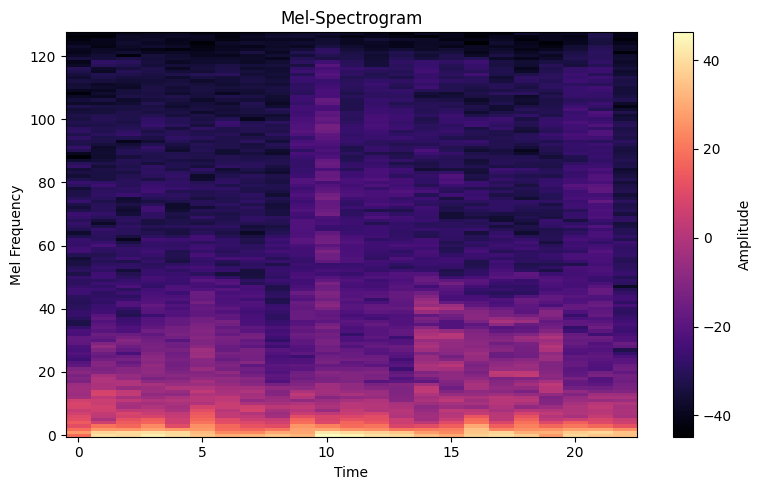

In [17]:
import matplotlib.pyplot as plt
import torch

# 1. 데이터 가져오기
spec = train_dataset[0][0]  # shape: (1, 128, 63)

# 2. 채널 차원 제거
spec = spec.squeeze(0)  # shape: (128, 63)

# 3. 시각화
plt.figure(figsize=(8, 5))
plt.imshow(spec, origin='lower', aspect='auto', cmap='magma')  # 또는 cmap='inferno', 'viridis' 등
plt.colorbar(label='Amplitude')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torchaudio.transforms as T

# 🔹 각 파일별로 cycle segments 시각화
for i, cycle_data in enumerate(raw_cycle_list):
    filename = cycle_data['file']
    sample_rate = cycle_data['sr']
    segments = cycle_data['seg']

    print(f"파일: {filename}, 세그먼트 개수: {len(segments)}")

    # 🔹 전체 원본 db 스펙트로그램 (크게 출력)
    origin_db = segments[0]['db']  # 첫 번째 세그먼트에서 전체 db 스펙트로그램 사용

    print(f"Original dB Spectrogram shape: {origin_db.shape}")  # 🔹 데이터 shape 확인

    # 🔹 원본 dB Spectrogram을 크게 시각화
    fig, main_ax = plt.subplots(figsize=(15, 5))
    main_ax.imshow(origin_db.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
    main_ax.set_title(f"Original dB Spectrogram - {filename}")
    main_ax.set_xlabel("Time Frames")
    main_ax.set_ylabel("Frequency Bins")
    plt.show()

    # 세그먼트 개수에 맞게 서브플롯 생성 (원본 + 두 가지 Augment 버전)
    fig, axes = plt.subplots(len(segments), 3, figsize=(15, 5 * len(segments))) # plt.subplots(행, 열, figsize)

    # 세그먼트별로 반복하여 스펙트로그램 시각화
    for j, segment in enumerate(segments):
        mel_spectrogram = segment['mel']  # 원본 Mel Spectrogram
        augmented_spec1 = segment['aug'][0]  # 주파수 마스킹
        augmented_spec2 = segment['aug'][1]  # 시간 마스킹
        start_time, end_time = segment['period']

        # 한 개의 세그먼트만 있을 경우, `axes[j]` 대신 `axes`를 직접 사용
        if len(segments) > 1:
            ax1, ax2, ax3 = axes[j]
        else:
            ax1, ax2, ax3 = axes

        # 🔹 원본 Mel Spectrogram 시각화
        ax1.imshow(mel_spectrogram.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
        ax1.set_title(f"Original Mel Spectrogram (Cycle {j+1}: {start_time:.2f}s - {end_time:.2f}s)")
        ax1.set_xlabel("Time Frames")
        ax1.set_ylabel("Mel Bins")

        # 🔹 주파수 마스킹이 적용된 Mel Spectrogram 시각화
        ax2.imshow(augmented_spec1.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
        ax2.set_title(f"Augmented Mel (Freq Masking) (Cycle {j+1})")
        ax2.set_xlabel("Time Frames")
        ax2.set_ylabel("Mel Bins")

        # 🔹 시간 마스킹이 적용된 Mel Spectrogram 시각화
        ax3.imshow(augmented_spec2.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
        ax3.set_title(f"Augmented Mel (Time Masking) (Cycle {j+1})")
        ax3.set_xlabel("Time Frames")
        ax3.set_ylabel("Mel Bins")

    plt.tight_layout()
    plt.show()


#### 2.4 DataLoader

In [18]:
train_dataset[0]

(tensor([[[ 18.2739,  41.0651,  39.4717,  ...,  39.0717,  35.6136,  34.7371],
          [ 26.7610,  38.4059,  39.4080,  ...,  36.3724,  38.7695,  34.5259],
          [ 18.6967,  26.5022,  26.2651,  ...,  28.4122,  29.0566,  24.7872],
          ...,
          [-42.1164, -40.1613, -38.2948,  ..., -39.9382, -33.8735, -42.9880],
          [-43.9740, -43.6206, -37.8362,  ..., -41.0909, -32.5942, -41.4029],
          [-41.8878, -42.3428, -39.6249,  ..., -39.0022, -32.5291, -40.6569]]]),
 tensor([0., 1.]),
 ('103_2b2_Ar_mc_LittC2SE', np.float64(2.886)))

In [19]:
train_dataset[10][0].shape

torch.Size([1, 128, 24])

In [20]:
# ---------------- 학습 데이터 구성(seed) ----------------
seed_everything(args.seed)

# train_dataset 내에서 각 파일의 인덱스를 추출
pretrain_idx = []
finetune_idx = []

for i in range(len(train_dataset)):
    filename = train_dataset[i][2][0]

    if filename in pretrain_list:
        pretrain_idx.append(i)
    # elif filename in finetune_list:
    #     finetune_idx.append(i)

    # pretrain = finetune
    if filename in finetune_list:
        finetune_idx.append(i)

# 인덱스 순서 셔플
random.shuffle(pretrain_idx)
random.shuffle(finetune_idx)

print(f"Pretrain set size: {len(pretrain_idx)}, Finetune set size: {len(finetune_idx)}")

Pretrain set size: 4142, Finetune set size: 4142


코드 실행 환경에 따라 num_workers를 적절한 값으로 지정해주세요!

In [21]:
def collate_with_mask(batch):
    # batch: [(mel, label, extra), ...]
    mels, labels, extras = zip(*batch)  # 길이 B 튜플

    # 가장 긴 time length 찾기
    max_T = max([mel.shape[-1] for mel in mels])  # ex) 22, 26 → 26
    PAD_DB = -100.0  # dB 스케일 기준 최소값으로 padding

    padded_mels = []
    masks = []

    for mel in mels:
        # mel: (1, F, T)  e.g., (1, 128, 24)
        _, F, T = mel.shape
        mel = mel.squeeze(0)  # → (F, T)

        pad_len = max_T - T
        if pad_len > 0:
            # Pad 생성 및 mel concat
            pad = mel.new_full((F, pad_len), fill_value=PAD_DB)  # (F, pad_len)
            mel_padded = torch.cat([mel, pad], dim=-1)  # (F, max_T)

            mask = torch.cat([torch.ones(T), torch.zeros(pad_len)])  # (max_T,)
        else:
            mel_padded = mel  # (F, max_T)
            mask = torch.ones(T)  # (max_T)

        # 다시 (1, F, T)로 복원
        padded_mels.append(mel_padded.unsqueeze(0))  # (1, F, T)
        masks.append(mask)

    # 최종 batch 텐서화
    padded_mels = torch.stack(padded_mels, dim=0)  # (B, 1, F, T)
    masks = torch.stack(masks).bool()              # (B, T)

    return padded_mels, torch.stack(labels), masks, extras

In [22]:
# # Dataset 생성 (Subset)
# pretrain_dataset = Subset(train_dataset, pretrain_idx)
# finetune_dataset = Subset(train_dataset, finetune_idx)

# # DataLoader 생성
# # DataLoader에서 shuffle=True로 지정하면 매 epoch마다 셔플 순서가 달라짐 => 재현성 문제 발생
# # pretrain_dataset, finetune_dataset은 이미 셔플이 완료된 것으로, 이것을 DataLoader에 입력함
# pretrain_loader = DataLoader(
#     pretrain_dataset,
#     batch_size=args.batch_size,
#     num_workers=0,
#     drop_last=True,
#     pin_memory=True,
#     shuffle=False
# )

# finetune_loader = DataLoader(
#     finetune_dataset,
#     batch_size=args.batch_size,
#     num_workers=0,
#     drop_last=True,
#     pin_memory=True,
#     shuffle=False
# )

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=args.batch_size,
#     num_workers=0,
#     pin_memory=True,
#     shuffle=False
# )

#########################
# Dataset 생성 (Subset)
pretrain_dataset = Subset(train_dataset, pretrain_idx)
finetune_dataset = Subset(train_dataset, finetune_idx)

# DataLoader 생성
# DataLoader에서 shuffle=True로 지정하면 매 epoch마다 셔플 순서가 달라짐 => 재현성 문제 발생
# pretrain_dataset, finetune_dataset은 이미 셔플이 완료된 것으로, 이것을 DataLoader에 입력함
pretrain_loader = DataLoader(
    pretrain_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    shuffle=True,
    collate_fn=collate_with_mask
)

finetune_loader = DataLoader(
    finetune_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    shuffle=True,
    collate_fn=collate_with_mask
)

test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    pin_memory=True,
    shuffle=True,
    collate_fn=collate_with_mask
)

label 분포 확인 (단순 참고용, 실제 환경에서는 pretrain set의 label 분포가 어떤지 알 수 없음)

In [23]:
from collections import Counter

# label
labels = torch.stack([multi_label for _, multi_label, _ in train_dataset])

# pretext와 finetune 데이터셋의 라벨 분포 출력
pretrain_labels = labels[pretrain_idx]
pretrain_labels_class = (
    pretrain_labels[:, 0].long() * 1 +  # crackle bit → *1
    pretrain_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}
finetune_labels = labels[finetune_idx]
finetune_labels_class = (
    finetune_labels[:, 0].long() * 1 +  # crackle bit → *1
    finetune_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

# test 데이터셋의 라벨 분포 출력
test_labels = torch.stack([multi_label for _, multi_label, _ in test_dataset])
test_labels_class = (
    test_labels[:, 0].long() * 1 +  # crackle bit → *1
    test_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

print(f"Pretrain sample: {len(pretrain_labels_class)}")
print("Pretrain label distribution:", Counter(pretrain_labels_class.tolist()))
print(f"\nFinetune sample: {len(finetune_labels_class)}")
print("Finetune label distribution:", Counter(finetune_labels_class.tolist()))
print(f"Test sample: {len(test_labels_class)}")
print("Test label distribution:", Counter(test_labels_class.tolist()))

Pretrain sample: 4142
Pretrain label distribution: Counter({0: 2063, 1: 1215, 2: 501, 3: 363})

Finetune sample: 4142
Finetune label distribution: Counter({0: 2063, 1: 1215, 2: 501, 3: 363})
Test sample: 2756
Test label distribution: Counter({0: 1579, 1: 649, 2: 385, 3: 143})


## 3. Modeling

#### 3.1 Pre-trained ResNet50

In [ ]:
# def backbone_resnet():
#     # 1. 기본 ResNet50 생성 (pretrained=False로 시작)
#     resnet = models.resnet50(pretrained=False)

#     # 2. 첫 번째 conv 레이어를 1채널용으로 수정
#     resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#     # 먼저 fc 제거
#     resnet.fc = nn.Identity()

#     # 3. ImageNet 가중치 로드 (conv1 제외)
#     state_dict = load_state_dict_from_url(
#         'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#         progress=True
#     )
#     if 'conv1.weight' in state_dict:
#         del state_dict['conv1.weight']
#     resnet.load_state_dict(state_dict, strict=False)

#     return resnet

In [24]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNet50(torchvision.models.resnet.ResNet):
    def __init__(self, track_bn=True):
        def norm_layer(*args, **kwargs):
            return nn.BatchNorm2d(*args, **kwargs, track_running_stats=track_bn)
        super().__init__(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], norm_layer=norm_layer)
        del self.fc
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.final_feat_dim = 2048

    def load_sl_official_weights(self, progress=True):
        weights = ResNet50_Weights.DEFAULT
        state_dict = weights.get_state_dict(progress=progress)

        del state_dict['conv1.weight']
        missing, unexpected = self.load_state_dict(state_dict, strict=False)
        # if len(missing) > 0:
            # raise AssertionError('Model code may be incorrect')

    def load_ssl_official_weights(self, progress=True):
        # only SimCLR is available
        from pl_bolts.models.self_supervised import SimCLR
        
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
        simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)

        state_dict = {}
        for k, v in simclr.state_dict().items():
            if 'encoder.' in k:
                k = k.replace('encoder.', '')
            if 'fc' not in k or 'project' not in k:
                state_dict[k] = v
        missing, unexpected = self.load_state_dict(state_dict, strict=False)
        # non_linear_evaluator.block_forward is a pretrained MLP classifier for SimCLR
        # refer to https://github.com/Lightning-AI/lightning-bolts/blob/bcbbf6ab6c36430946dd8a416ddc7e697e8507fc/pl_bolts/models/self_supervised/evaluator.py#L7
        if len(missing) > 0:
            raise AssertionError('Model code may be incorrect')

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # x = self.fc(x)

        return x

In [25]:
def backbone_resnet50_patch():
    """
    MoCo 구조에 사용할 CNN6 백본 정의 함수.
    
    주요 변경 사항:
    - ResNet50 대신 CNN6 클래스 사용
    - 출력 feature dim은 512로 고정됨 (MoCo에서는 dim_enc=2048 → 이 부분만 맞춰서 사용하면 문제 없음)
    - ImageNet pretrained 사용 대신 공식 CNN6 pretrained 로딩 함수 포함 (옵션 사용 가능)
    """
    model = ResNet50()

    # 공식 SL pretrained weight를 사용하고자 할 경우 아래 줄을 주석 해제
    model.load_sl_official_weights()

    return model


#### 3.2 Pre-trained CNN6

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            

def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)


class ConvBlock5x5(nn.Module): #for CNN6
    def __init__(self, in_channels, out_channels, stride=(1,1)):
        
        super(ConvBlock5x5, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(5, 5), stride=stride,
                              padding=(2, 2), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_bn(self.bn1)
        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')
        
        return x


class CNN6(nn.Module):
    def __init__(self):
        super(CNN6, self).__init__()
        self.final_feat_dim = 512

        self.do_dropout = False
        self.conv_block1 = ConvBlock5x5(in_channels=1, out_channels=64, stride=(1,1))
        self.conv_block2 = ConvBlock5x5(in_channels=64, out_channels=128, stride=(1,1))
        self.conv_block3 = ConvBlock5x5(in_channels=128, out_channels=256, stride=(1,1))
        self.conv_block4 = ConvBlock5x5(in_channels=256, out_channels=512, stride=(1,1))
        self.dropout = nn.Dropout(0.2)
        # self.linear = nn.Linear(512, num_classes, bias=True)

    def load_sl_official_weights(self):
        """ download AudioSet pretrained CNN6 in https://zenodo.org/record/3960586#.Y8dz8y_kEiY
        """
        weights = torch.load('/home/ressera3/boaz/pretrained_pth/Cnn6_mAP=0.343.pth')['model']
        state_dict = {k: v for k, v in weights.items() if k in self.state_dict().keys()}
        missing, unexpected = self.load_state_dict(state_dict, strict=False)

    def forward(self, x):
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)

        x = torch.mean(x, dim=3) #mean over time dim
        (x1, _) = torch.max(x, dim=2) #max over freq dim
        x2 = torch.mean(x, dim=2) #mean over freq dim (after mean over time)
        x = x1 + x2

        # if self.embed_only:
        #     return x
        # return self.linear(x)
        return x

In [27]:
def backbone_cnn6():
    """
    MoCo 구조에 사용할 CNN6 백본 정의 함수.
    
    주요 변경 사항:
    - ResNet50 대신 CNN6 클래스 사용
    - 출력 feature dim은 512로 고정됨 (MoCo에서는 dim_enc=2048 → 이 부분만 맞춰서 사용하면 문제 없음)
    - ImageNet pretrained 사용 대신 공식 CNN6 pretrained 로딩 함수 포함 (옵션 사용 가능)
    """
    model = CNN6()

    # 공식 SL pretrained weight를 사용하고자 할 경우 아래 줄을 주석 해제
    model.load_sl_official_weights()

    return model


##### 3-3. GRU+ATT


In [30]:
class HAN_GRU(nn.Module):
    def __init__(self, freq_dim=128, hidden_freq=100, hidden_time=250, output_dim=512):
        super(HAN_GRU, self).__init__()
        self.hidden_freq = hidden_freq
        self.hidden_time = hidden_time
        self.output_dim = output_dim

        # Bidirectional GRU (주파수 영역)
        self.freq_gru = nn.GRU(input_size=freq_dim, hidden_size=hidden_freq,
                               batch_first=True, bidirectional=True)

        # Attention for frequency
        self.freq_attn_fc = nn.Linear(hidden_freq * 2, hidden_freq * 2)
        self.freq_context_vector = nn.Parameter(torch.randn(hidden_freq * 2))

        # Bidirectional GRU (시간 영역)
        self.time_gru = nn.GRU(input_size=hidden_freq * 2, hidden_size=hidden_time,
                               batch_first=True, bidirectional=True)

        # Attention for time
        self.time_attn_fc = nn.Linear(hidden_time * 2, hidden_time * 2)
        self.time_context_vector = nn.Parameter(torch.randn(hidden_time * 2))

        # 마지막 출력 벡터 차원 맞추기
        self.fc_out = nn.Linear(hidden_time * 2, output_dim)

    def attention(self, rnn_output, attn_fc, context_vector, mask=None):
        u = torch.tanh(attn_fc(rnn_output))  # [B, T, D]
        attn_scores = torch.matmul(u, context_vector)  # [B, T]

        if mask is not None:
            # mask가 0인 (padding) 위치의 attention score를 -1e9로 설정 → softmax 이후 거의 0이 됨
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        attn_weights = torch.softmax(attn_scores, dim=1)  # [B, T]
        attn_output = torch.sum(rnn_output * attn_weights.unsqueeze(-1), dim=1)  # [B, D]
        return attn_output

    def forward(self, x, mask=None):
        # x: (B, C=1, F, T) → squeeze channel
        x = x.squeeze(1)   # (B, F, T)
        x = x.permute(0, 2, 1)  # (B, T, F)

        # Frequency GRU
        freq_output, _ = self.freq_gru(x)  # (B, T, 2*hidden_freq)
        freq_attn_output = self.attention(freq_output, self.freq_attn_fc, self.freq_context_vector, mask)  # (B, 2*hidden_freq)

        # 시간 축을 따라 Attention-GRU
        time_input = freq_output  # (B, T, 2*hidden_freq)
        time_output, _ = self.time_gru(time_input)  # (B, T, 2*hidden_time)
        time_attn_output = self.attention(time_output, self.time_attn_fc, self.time_context_vector, mask)  # (B, 2*hidden_time)

        # 최종 임베딩 차원으로 투사
        # out = self.fc_out(time_attn_output)  # (B, output_dim)
        return time_attn_output


In [31]:
def backbone_han_gru():
    """
    MoCo에 사용 가능한 GRU + 계층적 Attention 기반 백본 모델 정의.
    - 입력: log-mel spectrogram 형태 (B, 1, F, T)
    - 출력: 512차원 feature vector
    """
    return HAN_GRU()

In [32]:
# summary 함수 사용: (채널, 높이, 너비) 크기를 지정
summary(backbone_han_gru().to(device), input_size=(1, 128, 63))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 63, 200], [-1, 2, 100]]               0
            Linear-2              [-1, 63, 200]          40,200
               GRU-3  [[-1, 63, 500], [-1, 2, 250]]               0
            Linear-4              [-1, 63, 500]         250,500
Total params: 290,700
Trainable params: 290,700
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 139.05
Params size (MB): 1.11
Estimated Total Size (MB): 140.19
----------------------------------------------------------------


#### 3.2 MoCo (MLS)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# K: queue_g의 크기
# dim_enc: projector 통과 전, g1,g2 벡터의 차원
# dim_prj: projector 통과 후, z1,z2 벡터의 차원
class MoCo(nn.Module):
    def __init__(self, base_encoder, dim_enc=512, dim_prj=128, K=512, m=0.999, T=0.07, top_k=10, lambda_bce=0.5):
        super().__init__()
        self.K = K
        self.m = m
        self.T = T
        self.top_k = top_k
        self.lambda_bce = lambda_bce

        self.encoder_q = base_encoder()
        self.encoder_k = base_encoder()

        # dim_enc = 2048
        if dim_enc == 2048:
            self.proj_head_q = nn.Sequential(
                nn.Linear(dim_enc, dim_enc),
                nn.BatchNorm1d(dim_enc),
                nn.GELU(),
                nn.Linear(dim_enc, dim_prj)
            )
            self.proj_head_k = nn.Sequential(
                nn.Linear(dim_enc, dim_enc),
                nn.BatchNorm1d(dim_enc),
                nn.GELU(),
                nn.Linear(dim_enc, dim_prj)
            )

        elif dim_enc == 500:
            self.proj_head_q = nn.Sequential(
                nn.Linear(dim_enc, dim_enc),
                nn.BatchNorm1d(dim_enc),
                nn.ReLU(),
                nn.Linear(dim_enc, dim_prj)
            )
            self.proj_head_k = nn.Sequential(
                nn.Linear(dim_enc, dim_enc),
                nn.BatchNorm1d(dim_enc),
                nn.ReLU(),
                nn.Linear(dim_enc, dim_prj)
            )
            print(f"[INFO] Using CNN6 backbone with dim_enc={dim_enc} and dim_prj={dim_prj}")

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        self.register_buffer("queue_g", F.normalize(torch.randn(dim_enc, K), dim=0))      # g2를 정규화한 후 열 단위로 Qg에 저장
        self.register_buffer("queue_z", F.normalize(torch.randn(dim_prj, K), dim=0))      # z2를 정규화한 후 열 단위로 Qz에 저장
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))      
        
        # Top-k 확인용 버퍼
        self.register_buffer("queue_label", torch.zeros(K, 2))  # or float for multi-label

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, g2, z2, labels=None):
        batch_size = g2.shape[0]
        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0
        # self.queue_g[:, ptr:ptr + batch_size] = g2.T.detach()[:, :self.queue_g.shape[1] - ptr]  # Update only available space
        # self.queue_z[:, ptr:ptr + batch_size] = z2.T.detach()[:, :self.queue_z.shape[1] - ptr]  # Update only available space
        self.queue_g[:, ptr:ptr+batch_size] = g2.T.detach()
        self.queue_z[:, ptr:ptr+batch_size] = z2.T.detach()

        # label 확인용
        if labels is not None:
            self.queue_label[ptr:ptr+batch_size] = labels.detach()
            
        self.queue_ptr[0] = (ptr + batch_size) % self.K

    def forward(self, im_q, im_k, epoch=None, warmup_epochs=10, labels_k=None, mask=None):
        # encoder_q → g1 (feature)
        g1 = F.normalize(self.encoder_q(im_q, mask=mask), dim=1)  # shape: [B, 2048]

        # projection head → z1
        z1 = F.normalize(self.proj_head_q(g1), dim=1)  # shape: [B, 128]

        # encoder k
        with torch.no_grad():
            self._momentum_update_key_encoder()
            g2 = F.normalize(self.encoder_k(im_k, mask=mask), dim=1)
            z2 = F.normalize(self.proj_head_k(g2), dim=1)

        # top-k mining
        sim_g = torch.matmul(g1, self.queue_g.clone().detach())  # [N, K]
        # Ablation(1-1) Hard top-k
        topk_idx = torch.topk(sim_g, self.top_k, dim=1).indices
        y = torch.zeros_like(sim_g)
        y.scatter_(1, topk_idx, 1.0)
        # # Ablation(1-2) Soft top-k
        # topk_sim, topk_idx = torch.topk(sim_g, self.top_k, dim=1)
        # y = torch.zeros_like(sim_g)
        # y.scatter_(1, topk_idx, F.softmax(topk_sim / self.T, dim=1))

        ##################################################################
        # logits from z1 · Qz
        sim_z = torch.matmul(z1, self.queue_z.clone().detach())
        # Ablation(2-1) BCE Loss
        bce_loss = F.binary_cross_entropy_with_logits(sim_z / self.T, y) # 개선-> sigmoid(sim_z), 1/D

        # # Ablation(2-2) Weighted BCE Loss
        # pos_weight = torch.ones_like(sim_z) * (self.K / self.top_k)
        # bce_loss = F.binary_cross_entropy_with_logits(sim_z / self.T, y, pos_weight=pos_weight)
        # # Ablation(2-3) another Weighted BCE Loss (비추, top-k만 보는 느낌)
        # raw_loss = F.binary_cross_entropy_with_logits(sim_z / self.T, y, reduction='none')  # shape: [B, K]
        # bce_loss = raw_loss.sum() / (y.sum() + 1e-6)

        ###################################################################
        # InfoNCE loss
        l_pos = torch.sum(z1 * z2, dim=1, keepdim=True)
        l_neg = torch.matmul(z1, self.queue_z.clone().detach())
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(logits.device)
        info_nce_loss = F.cross_entropy(logits, labels)

        # Total loss (with optional warmup) # MLS 논문에서는 warmup 아예 안쓴다고 함
        if epoch is not None and epoch < warmup_epochs:
            loss = info_nce_loss
        else:
            loss = info_nce_loss + self.lambda_bce * bce_loss

        self._dequeue_and_enqueue(g2, z2, labels=labels_k)

        return loss, logits, labels

## 4. Pretrain

In [34]:
len(next(iter(pretrain_loader)))

4

In [35]:
loader_iter = iter(pretrain_loader)
batch1 = next(loader_iter)
batch2 = next(loader_iter)

In [36]:
next(iter(pretrain_loader))[0].shape

torch.Size([128, 1, 128, 62])

In [37]:
batch2[0].shape

torch.Size([128, 1, 128, 127])

In [40]:
# 모델 지정하기 전 seed 고정 필요
seed_everything(args.seed) # Seed 고정

pretrain_project_name = f'shuffle_GRU+ATT500_MLS_PT_{args.batch_size}bs_N+PS_{get_timestamp()}'

# wandb 초기화 (프로젝트명, 실험 이름 등 설정)
wandb.init(
    project="0718_SBW_ICBHI_MSL_all", # 프로젝트 이름
    name=f"{pretrain_project_name}",  # 실험 이름
    config={
        "epochs": args.epochs,
        "batch_size": args.batch_size,
        "lr": args.lr,
        "momentum": args.momentum,
        "weight_decay": args.weight_decay
    }
)

# 1. MoCo 모델 생성
model = MoCo(
    base_encoder = backbone_han_gru,
    dim_enc = 500, # CNN6의 출력 feature dim (default=2048)
    dim_prj = args.dim_prj,
    K = args.K,
    m = args.momentum,
    T = args.T,
    top_k = args.top_k,
    lambda_bce = args.lambda_bce
).cuda()

# 2. Optimizer
optimizer = torch.optim.AdamW(model.parameters(), args.lr, weight_decay=args.weight_decay)

# 3. Cosine Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=1e-6)

# 4. Train
# Best loss 초기화
best_loss = float('inf')
best_epoch = -1

def multilabel_to_multiclass(y):
    # Crackle → 1, Wheeze → 2, Both → 3, None → 0
    y = np.array(y)
    return y[:, 0] + y[:, 1] * 2

for epoch in range(args.epochs):
    # ===============================
    # Training
    # ===============================
    model.train()
    total_train_loss = 0.0

    for i, (repeat_mel, label, mask, _) in enumerate(pretrain_loader): # label 여기선 사용 X
        im_q, im_k, _ = aug(repeat_mel)
        # 디버깅: 데이터 자체 확인
        im_q = im_q.cuda(device=args.gpu, non_blocking=True)
        im_k = im_k.cuda(device=args.gpu, non_blocking=True)

        optimizer.zero_grad()
        loss, output, target = model(im_q=im_q, im_k=im_k, labels_k=label.cuda(), mask=mask.cuda())
        loss.backward()
        optimizer.step()

        if i == 0:
            first_feature = F.normalize(model.encoder_q(im_q[0:1]), dim=1)
            sim = torch.matmul(first_feature, model.queue_g.clone().detach())
            topk_indices = torch.topk(sim, model.top_k, dim=1).indices[0]

            # 🔽 상위 10개만 사용하도록 슬라이싱
            topk_indices_10 = topk_indices[:10]
            topk_sims = sim[0, topk_indices_10].detach().cpu().numpy()
            topk_labels = model.queue_label[topk_indices_10].cpu().numpy()

            true_label = label[0].cpu().numpy().reshape(1, -1)
            true_class = multilabel_to_multiclass(true_label)[0]
            topk_classes = multilabel_to_multiclass(topk_labels)

            print(f"\n[Top-k Label Logging] Epoch {epoch}")
            print(f" - Query label (multi-class): {true_class} / Raw: {true_label.tolist()}")
            print(f"{'Rank':<6}{'Index':<8}{'Sim':<10}{'Class':<8}{'Raw Label'}")
            print("-" * 45)

            # wandb Table 생성
            topk_table = wandb.Table(columns=["Rank", "Index", "Similarity", "Class", "Raw Label"])
            for rank, (idx, sim_val, cls, raw_lbl) in enumerate(zip(topk_indices_10.cpu().numpy(), topk_sims, topk_classes, topk_labels)):
                print(f"{rank+1:<6}{idx:<8}{sim_val:<10.4f}{cls:<8}{raw_lbl}")
                topk_table.add_data(rank+1, idx, float(sim_val), int(cls), raw_lbl.tolist())

        total_train_loss += loss.item()

        total_train_loss += loss.item() 
        
    avg_train_loss = total_train_loss / len(pretrain_loader)
    print(f"[Epoch {epoch} | Step {i}] im_q: {im_q.shape}, im_k: {im_k.shape}")


    # =====================================
    # Scheduler
    # =====================================
    scheduler.step()

    # =====================================
    # Logging with wandb
    # =====================================
    current_lr = optimizer.param_groups[0]['lr']
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "lr": current_lr,
        "Pretrain_TopK": topk_table
    })

    # =====================================
    # Checkpoint (Every 100 epochs)
    # =====================================
    if (epoch + 1) % 100 == 0:
        ckpt_path = CHECKPOINT_PATH + f"/{pretrain_project_name}_{epoch:03d}.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, ckpt_path)
        print(f"💾 Saved checkpoint to {ckpt_path}")

    # ===============================
    # Save Best Checkpoint
    # ===============================
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        best_epoch = epoch
        best_ckpt_path = CHECKPOINT_PATH + f"/{pretrain_project_name}_best_checkpoint.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_loss
        }, best_ckpt_path)
        print(f"=> Saved best checkpoint (epoch: {epoch}, loss: {best_loss:.4f})")

[INFO] Using CNN6 backbone with dim_enc=500 and dim_prj=128


/opt/conda/envs/boaz/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.gru(



[Top-k Label Logging] Epoch 0
 - Query label (multi-class): 2.0 / Raw: [[0.0, 1.0]]
Rank  Index   Sim       Class   Raw Label
---------------------------------------------
1     104     0.1689    0.0     [0. 0.]
2     442     0.1267    0.0     [0. 0.]
3     353     0.1262    0.0     [0. 0.]
4     417     0.1113    0.0     [0. 0.]
5     60      0.1088    2.0     [0. 1.]
6     174     0.1086    0.0     [0. 0.]
7     127     0.1084    1.0     [1. 0.]
8     109     0.1064    1.0     [1. 0.]
9     9       0.1062    0.0     [0. 0.]
10    18      0.1049    0.0     [0. 0.]
[Epoch 0 | Step 31] im_q: torch.Size([128, 1, 128, 54]), im_k: torch.Size([128, 1, 128, 54])
=> Saved best checkpoint (epoch: 0, loss: 15.0364)

[Top-k Label Logging] Epoch 1
 - Query label (multi-class): 0.0 / Raw: [[0.0, 0.0]]
Rank  Index   Sim       Class   Raw Label
---------------------------------------------
1     9       0.3667    1.0     [1. 0.]
2     14      0.3603    0.0     [0. 0.]
3     57      0.3568    0.0   

## 5. Linear Evaluation

In [ ]:
wandb.finish

#### validate

In [41]:
len(test_dataset)

2756

In [42]:
def validate(model, val_loader, criterion, device):
    import numpy as np
    from sklearn.metrics import confusion_matrix

    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, mask, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).int()  # threshold = 0.5
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()   # [N, 2]
    all_labels = torch.cat(all_labels, dim=0).numpy() # [N, 2]

    avg_loss = running_loss / len(val_loader)

    # # 개별 label별 sensitivity/specificity 계산
    # crackle_sens = crackle_spec = wheeze_sens = wheeze_spec = 0

    # for i in range(2):
    #     y_true = all_labels[:, i]
    #     y_pred = all_preds[:, i]

    #     cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    #     if cm.shape == (2, 2):
    #         TN, FP, FN, TP = cm.ravel()
    #     else:
    #         TN = FP = FN = TP = 0  # 안전처리

    #     sens = TP / (TP + FN + 1e-6)
    #     spec = TN / (TN + FP + 1e-6)

    #     if i == 0:
    #         crackle_sens, crackle_spec = sens, spec
    #     else:
    #         wheeze_sens, wheeze_spec = sens, spec

    # avg_sens = (crackle_sens + wheeze_sens) / 2
    # avg_spec = (crackle_spec + wheeze_spec) / 2
    # icbhi_score = (avg_sens + avg_spec) / 2

    return avg_loss, all_labels, all_preds


### Weighted loss

In [43]:
from collections import Counter
import torch
import numpy as np

# 💡 다중 라벨 예시: targets는 [B, C] binary matrix (e.g., [1, 0, 1, 0])
label_list = []

# 👇 train_dataset이 (x, multi_label_tensor, _) 형태라고 가정
for _, label, _ in test_dataset:
    label_list.append(label)  # label: Tensor([0, 1, 0, 1])처럼

# 전체 label을 합치기
all_labels = torch.stack(label_list, dim=0)  # shape: [N, C]
num_classes = all_labels.size(1)
total_samples = all_labels.size(0)

# 클래스별 1의 개수 세기
class_counts = all_labels.sum(dim=0)  # shape: [C]
class_weights = total_samples / (num_classes * class_counts + 1e-6)  # smoothed

# tensor로 변환
class_weights_tensor = class_weights.float().to(device)

# 🔹 출력
for i, count in enumerate(class_counts.tolist()):
    print(f"Class {i} - Positives (1): {int(count)} / {total_samples} samples")
print(f"Class Weights: {class_weights_tensor}")

alpha_norm = class_weights_tensor / class_weights_tensor.sum()
print(f"alpha_norm: {alpha_norm}")

Class 0 - Positives (1): 792 / 2756 samples
Class 1 - Positives (1): 528 / 2756 samples
Class Weights: tensor([1.7399, 2.6098], device='cuda:0')
alpha_norm: tensor([0.4000, 0.6000], device='cuda:0')


In [44]:
import torch

# ⚙️ 각 클래스의 positive 개수 (from label distribution)
crackle_pos = 262 + 83  # label 1 or 3
wheeze_pos  = 84 + 83   # label 2 or 3

total_samples = 885
num_classes = 2

# ⚖️ 기본 class weight 계산: inverse frequency
class_counts = torch.tensor([crackle_pos, wheeze_pos], dtype=torch.float)
class_weights = total_samples / (num_classes * class_counts + 1e-6)

# ✅ 정규화: sum = 1
alpha_norm = class_weights / class_weights.sum()

# 출력
print("Raw Class Weights:", class_weights)
print("Normalized Alpha (sum=1):", alpha_norm)


Raw Class Weights: tensor([1.2826, 2.6497])
Normalized Alpha (sum=1): tensor([0.3262, 0.6738])


### Multi-label Focal Loss

In [45]:
import torch.nn.functional as F
import torch.nn as nn

class MultiLabelFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # Tensor of shape [C], or scalar
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        logits: [B, C] - raw scores
        targets: [B, C] - binary or soft labels
        """
        probs = torch.sigmoid(logits)  # [B, C]
        ce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')  # [B, C]

        pt = probs * targets + (1 - probs) * (1 - targets)  # p_t
        focal_weight = (1 - pt) ** self.gamma               # (1 - pt)^γ

        loss = focal_weight * ce_loss                       # focal weight 적용

        if self.alpha is not None:
            alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)  # [B, C]
            loss = alpha_factor * loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class StableMultiLabelFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', eps=1e-6):
        super().__init__()
        self.alpha = alpha  # tensor of shape [C] or None
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = torch.clamp(probs, min=self.eps, max=1.0 - self.eps)

        # Focal weight
        pt = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - pt) ** self.gamma

        # BCE loss
        ce_loss = - (targets * torch.log(probs) + (1 - targets) * torch.log(1 - probs))

        loss = focal_weight * ce_loss

        # Safe alpha (class weights) application
        if self.alpha is not None:
            if self.alpha.dim() == 1:
                alpha = self.alpha.view(1, -1)  # reshape for broadcasting
            else:
                alpha = self.alpha
            loss = alpha * loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [46]:
from collections import Counter
import torch

label_dist = Counter({0:456, 1:262, 2:84, 3:83})  # Finetune 분포

# Crackle: (1 + Both), Wheeze: (2 + Both)
n_crackle = label_dist[1] + label_dist[3]  # 262 + 83
n_wheeze  = label_dist[2] + label_dist[3]  # 84 + 83
n_total   = sum(label_dist.values())       # 885

pos_weight = torch.tensor([
    (n_total - n_crackle) / (n_crackle + 1e-6),
    (n_total - n_wheeze) / (n_wheeze + 1e-6)
], device=device)

print(pos_weight)

tensor([1.5652, 4.2994], device='cuda:0')


#### Linear Evaluation

In [39]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train_loss,█▇▆▅▅▄▄▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
lr,0.0
train_loss,4.7661


In [47]:
## Wandb 정의

# import wandb
finetune_project_name = f'GRU+ATT_500_MLS_LE_Abl(3.2)_alphaX_gamma2.0_best_N+PS_{args.batch_size}bs_{get_timestamp()}'

# wandb 초기화 (프로젝트명, 실험 이름 등 설정)
wandb.init(
    project="0718_SBW_ICBHI_MSL_all",           # 프로젝트 이름
    name=f"{finetune_project_name}", # 실험 이름
    config={
        "epochs": args.ft_epochs,
        "batch_size": args.batch_size,
        "lr": args.lr,
        "momentum": args.momentum,
        "weight_decay": args.weight_decay,
    }
)

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
lr,█████████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▁▁▁▁▁
train_loss,█▇▆█▇▇▆▅▅▅▄▄▅▅▅▅▄▄▃▄▃▃▃▃▄▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁
epoch,299
lr,0.0
train_loss,5.95263


In [48]:
# ===GemPooling (적응형 pooling)===
class GeM2DSequential(nn.Module):
    def __init__(self, p=3.0):
        super().__init__()
        self.freq_pool = GeMPool2d_dim(2, p=p)  # frequency
        self.time_pool = GeMPool2d_dim(3, p=p)  # time

    def forward(self, x):
        x = self.freq_pool(x)  # [B, C, 1, T]
        x = self.time_pool(x)  # [B, C, 1, 1]
        return x.squeeze(-1).squeeze(-1)  # [B, C]

class GeMPool2d_dim(nn.Module):
    def __init__(self, dim, p=3.0, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps
        self.dim = dim

    def forward(self, x):
        # reduce specified dim only
        if self.dim == 2:  # frequency
            return x.clamp(min=self.eps).pow(self.p).mean(dim=2, keepdim=True).pow(1. / self.p)
        elif self.dim == 3:  # time
            return x.clamp(min=self.eps).pow(self.p).mean(dim=3, keepdim=True).pow(1. / self.p)
        else:
            raise ValueError("Invalid dimension for GeM pooling")

# =======================================================================================

In [50]:
import os
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Model Load
# 위에서부터 했다면
# load_ckpt_path = CHECKPOINT_PATH + f"/{pretrain_project_name}_best_checkpoint.pth.tar"
# aug_pth_path = "/content/drive/MyDrive/2025_BOAZ_ICBHI/aug_pth"

# for gam in [2.0,2.3,2.7,3.0]:
# # import wandb
# finetune_project_name = f'ReICBHI_MLS_LE_Abl(3.2)_alphaX_gamma{gam}_last_N+TS_{args.batch_size}bs_{get_timestamp()}'

# # wandb 초기화 (프로젝트명, 실험 이름 등 설정)
# wandb.init(
#     project="ICBHI_MSL_Ablation_all",           # 프로젝트 이름
#     name=f"{finetune_project_name}", # 실험 이름
#     config={
#         "epochs": args.ft_epochs,
#         "batch_size": args.batch_size,
#         "lr": args.lr,
#         "momentum": args.momentum,
#         "weight_decay": args.weight_decay,
#     }
# )

# 중간부터 이어서 한다면
load_ckpt_path = "/home/ressera3/BOAZ-Chungzins/notebook/0710note_ckp/shuffle_GRU+ATT500_MLS_PT_128bs_N+PS_2507190020_best_checkpoint.pth.tar"
save_ckpt_path = CHECKPOINT_PATH+"/LE_pth"

# 재현성을 위한 시드 재설정
seed_everything(args.seed)

# MoCo 모델 생성 및 체크포인트 로드
model_eval = MoCo(
    base_encoder=backbone_han_gru,
    dim_enc=500,  # CNN6의 출력 feature dim (default=2048)
    dim_prj=args.dim_prj,
    K=args.K,
    m=args.momentum,
    T=args.T,
    top_k=args.top_k,
    lambda_bce=args.lambda_bce
)

checkpoint = torch.load(load_ckpt_path, map_location=device)
model_eval.load_state_dict(checkpoint["state_dict"])

# 사전 학습된 encoder 추출
encoder = model_eval.encoder_q.eval().to(device)

# 2. Dataset 정의
# Dataset 정의는 이미 되어있음 - test_loader

# =========================================================================

# 3. Fine-tuning을 위한 분류 모델 정의 ( Data 개수 작으므로, encoder 파라미터 frozen )
class FineTuningModel(nn.Module):
    def __init__(self, encoder, out_dim=args.out_dim, num_classes=2):
        super().__init__()
        self.encoder = encoder
        # 마지막 FC layer를 제외한 encoder의 모든 레이어 freeze
        for param in self.encoder.parameters():
            param.requires_grad = False

        # 새로운 분류 헤드 추가
        self.classifier = nn.Linear(out_dim, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

# class FineTuningModel(nn.Module):
#     def __init__(self, encoder, out_dim=2048, num_classes=2):
#         super().__init__()
#         self.encoder = encoder
#         for param in self.encoder.parameters():
#             param.requires_grad = False

#         self.pooling = GeM2DSequential()

#         self.classifier = nn.Sequential(
#             nn.BatchNorm1d(out_dim),
#             nn.Dropout(0.5),
#             nn.Linear(out_dim, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, num_classes)
#         )

#     def forward(self, x):
#         x = self.encoder(x)  # [B, 2048, F, T]
#         x = self.pooling(x)  # [B, 2048]
#         return self.classifier(x)

# 재현성을 위한 시드 재설정
seed_everything(args.seed)

# 4. 모델, 손실 함수, 옵티마이저 설정 / #CNN6 =>  out_dim = 512
model = FineTuningModel(encoder, out_dim = 500).to(device)
##############################

# # Ablation(3-1) LE -> BCE Loss
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


# # Ablation(3-2) LE -> Multi-label Focal Loss
# criterion = MultiLabelFocalLoss(
#     alpha=alpha_norm.to(device),  # 정규화된 값
#     gamma=2.0,                    # hard label일 경우
#     reduction='mean'
# )
# Ablation(3-2) LE -> Multi-label Focal Loss
# criterion = MultiLabelFocalLoss(
#     # alpha=class_weights.to(device),  # 정규화된 값
#     gamma=2.0,                    # hard label일 경우
#     reduction='mean'
# )

############################
optimizer = optim.AdamW(model.classifier.parameters(), lr=args.lr, weight_decay=args.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=args.ft_epochs, eta_min=1e-6)  # Linear Evaluation에서 epochs는 다르게 적용

# Best loss 초기화
best_loss = float('inf')
best_epoch = -1


# 5. Linear Evaluation
for epoch in range(args.ft_epochs):

    # ===============================
    # 1. Training
    # ===============================
    model.train()
    total_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0

    all_preds = []
    all_labels = []
    all_outputs = []

    pbar = tqdm(finetune_loader, desc='Linear Evaluation')
    for i, (cycle, labels, mask, _) in enumerate(pbar):
        # Forward pass
        cycle = cycle.cuda(args.gpu)
        labels = labels.cuda(args.gpu)

        # backpropagation
        optimizer.zero_grad()
        output = model(cycle)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # loss 계산
        total_loss += loss.item() # loss : -> float

        # 예측값과 실제값 저장 ( Ablation(4-1) threshold ?? )
        predicted = (torch.sigmoid(output) > 0.5).float()
        all_preds.append(predicted.detach().cpu())
        all_labels.append(labels.detach().cpu())
        all_outputs.append(output.detach().cpu())

    # train loss
    train_loss = total_loss / len(finetune_loader)

    # Concatenate
    all_preds = torch.cat(all_preds, dim=0).numpy()    # shape: [N, 2]
    all_labels = torch.cat(all_labels, dim=0).numpy()  # shape: [N, 2]
    all_output = torch.cat(all_outputs, dim=0).numpy()


    # ===============================
    # 2. 민감도/특이도 계산 (-> crakle+wheee 만 고려 = X)
    # ===============================

    #- origin-
    # crackle_sens = crackle_spec = wheeze_sens = wheeze_spec = 0

    # for i, label_name in enumerate(['Crackle', 'Wheeze']):
    #     y_true = all_labels[:, i]
    #     y_pred = all_preds[:, i]

    #     cm = confusion_matrix(y_true, y_pred)  # [[TN, FP], [FN, TP]]
    #     TN, FP, FN, TP = cm.ravel()

    #     sensitivity = TP / (TP + FN + 1e-6)
    #     specificity = TN / (TN + FP + 1e-6)

    #     if i == 0:
    #         crackle_sens = sensitivity
    #         crackle_spec = specificity
    #     elif i == 1:
    #         wheeze_sens = sensitivity
    #         wheeze_spec = specificity


    # finetune_train_sens = (crackle_sens + wheeze_sens) / 2
    # finetune_train_spec = (crackle_spec + wheeze_spec) / 2
    # finetune_icbhi_score = (finetune_train_sens + finetune_train_spec) / 2

    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}")
    # print(f"  [Average] Sens: {(crackle_sens+wheeze_sens)/2:.4f}, Spec: {(crackle_spec+wheeze_spec)/2:.4f}, Score: {(crackle_sens+crackle_spec+wheeze_sens+wheeze_spec)/4:.4f}")
    # print(f"  [Crackle] Sens: {crackle_sens:.4f}, Spec: {crackle_spec:.4f}, Score: {(crackle_sens+crackle_spec)/2:.4f}")
    # print(f"  [Wheeze]  Sens: {wheeze_sens:.4f}, Spec: {wheeze_spec:.4f}, Score: {(wheeze_sens+wheeze_spec)/2:.4f}")

    # =====================================
    # 2-Edited. Multi-class 민감도/특이도 계산
    # =====================================
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import wandb
    from sklearn.metrics import confusion_matrix

    def multilabel_to_multiclass(y):
        # Crackle → 1, Wheeze → 2, Both → 3, None → 0
        y = np.array(y)
        return y[:, 0] + y[:, 1]*2

    def evaluate_multiclass_confusion(y_true, y_pred, class_names=["Normal", "Wheeze", "Crackle", "Both"]):
        y_true_cls = multilabel_to_multiclass(y_true)
        y_pred_cls = multilabel_to_multiclass(y_pred)

        cm = confusion_matrix(y_true_cls, y_pred_cls, labels=[0, 1, 2, 3])

        # N_n: 정상 → 정상
        N_n = cm[0, 0]
        N_total = cm[0].sum()

        # 이상 클래스 정답 수: W, C, B
        W_total = cm[1].sum()
        C_total = cm[2].sum()
        B_total = cm[3].sum()

        # 각각의 정답 → 정확한 예측만 고려
        W_w = cm[1, 1]
        C_c = cm[2, 2]
        B_b = cm[3, 3]

        SP = N_n / (N_total + 1e-6) #spec
        SE = (W_w + C_c + B_b) / (W_total + C_total + B_total + 1e-6) #sense

        AS = (SP + SE) / 2
        HS = 2 * SP * SE / (SP + SE + 1e-6)

        return cm, SE, SP, y_true_cls, y_pred_cls

    def log_multiclass_conf_matrix_wandb(cm, class_names, sens, spec, normalize, tag):
        # Normalize (비율) 옵션
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
            fmt = '.2f'
            title = "Confusion Matrix (Normalized %)"
        else:
            fmt = 'd'
            title = "Confusion Matrix (Raw Count)"

        fig, ax = plt.subplots(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, ax=ax)

        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(title)

        icbhi_score = (sens + spec) / 2
        # 우하단에 성능 출력
        ax.text(
            0.99, 0.15,
            f"Sensitivity: {sens*100:.2f}%\nSpecificity: {spec*100:.2f}%\nICBHI Score: {icbhi_score*100:.2f}%",
            ha='right', va='bottom',
            transform=plt.gca().transAxes,
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
        )

        plt.tight_layout()
        # wandb.log({tag: wandb.Image(fig)})
        # plt.close(fig)
        return fig

    # 1. 4-class Confusion Matrix 평가
    class_names = ["Normal", "Crackle", "Wheeze", "Both"]
    cm_4x4, finetune_train_sens, finetune_train_spec, y_true_cls, y_pred_cls = evaluate_multiclass_confusion(all_labels, all_preds, class_names)
    finetune_icbhi_score = (finetune_train_sens + finetune_train_spec)/2

    print("4-Class Confusion Matrix:\n", cm_4x4)
    print(f"Sensitivity: {finetune_train_sens:.4f}, Specificity: {finetune_train_spec:.4f}, ICBHI Score: {finetune_icbhi_score:.4f}")


    # ===============================
    # 3. Validation
    # ===============================
    test_loss, test_labels, test_preds = validate(
        model, test_loader, criterion, device
    )

    precision = precision_score(test_labels, test_preds, average='macro')
    recall = recall_score(test_labels, test_preds, average='macro')
    f1 = f1_score(test_labels, test_preds, average='macro')

    test_cm_4x4, test_sens, test_spec, test_y_true_cls, test_y_pred_cls = evaluate_multiclass_confusion(test_labels, test_preds)
    test_icbhi_score = (test_sens+test_spec)/2

    print("[Validation] Confusion Matrix:\n", test_cm_4x4)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"[VALIDATION] Sensitivity: {test_sens:.4f}, Specificity: {test_spec:.4f}, Avg ICBHI Score: {(test_sens+test_spec)/2:.4f}")
    print("##################################################")


    # ===============================
    # 4. Confusion Matrix
    # ===============================

    # 2. Finetune Count Confusion Matrix 시각화
    fig_finetune_raw = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, finetune_train_sens, finetune_train_spec, normalize=False, tag="finetune_conf_matrix_raw")
    fig_finetune_norm = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, finetune_train_sens, finetune_train_spec, normalize=True, tag="finetune_conf_matrix_norm")

    # 3. Test Confusion Matrix 시각화
    fig_test_raw = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=False, tag="test_conf_matrix_raw")
    fig_test_norm = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=True, tag="test_conf_matrix_norm")

    # 4. log dictionary 생성
    wandb_log_dict = {
        "finetune_conf_matrix_raw": wandb.Image(fig_finetune_raw),
        "finetune_conf_matrix_norm": wandb.Image(fig_finetune_norm),
        "test_conf_matrix_raw": wandb.Image(fig_test_raw),
        "test_conf_matrix_norm": wandb.Image(fig_test_norm)
    }

    # =====================================
    # 5. Checkpoint (Every 50 epochs)
    # =====================================
    if (epoch + 1) % 50 == 0:
        ckpt_path = save_ckpt_path + f"{finetune_project_name}_{epoch:03d}.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, ckpt_path)
        print(f"💾 Saved checkpoint to {save_ckpt_path}")

    # ===============================
    # 6. Save Best Checkpoint
    # ===============================
    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch
        best_ckpt_path = save_ckpt_path + f"{finetune_project_name}_best.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_loss
        }, best_ckpt_path)
        print(f"=> Saved best checkpoint (epoch: {epoch}, loss: {best_loss:.4f})")


        # 🔹 Confusion Matrix Logging for Best
        cm_best, sens_best, spec_best,_, _ = evaluate_multiclass_confusion(test_labels, test_preds, class_names)
        fig_best_raw = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=False, tag="best_test_conf_matrix_raw")

        fig_best_norm = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=True, tag="best_test_conf_matrix_norm")

        wandb_log_dict.update({
            "best_test_conf_matrix_raw": wandb.Image(fig_best_raw),
            "best_test_conf_matrix_norm": wandb.Image(fig_best_norm)
        })


    if epoch == args.ft_epochs - 1:
        # 🔸 Confusion Matrix Logging for Last Epoch
        cm_last, sens_last, spec_last, _, _  = evaluate_multiclass_confusion(test_labels, test_preds, class_names)
        fig_last_raw = log_multiclass_conf_matrix_wandb(cm_last, class_names, sens_last, spec_last, normalize=False, tag="last_test_conf_matrix_raw")

        fig_last_norm = log_multiclass_conf_matrix_wandb(cm_last, class_names, sens_last, spec_last, normalize=True, tag="last_test_conf_matrix_norm")

        wandb_log_dict.update({
            "last_test_conf_matrix_raw": wandb.Image(fig_last_raw),
            "last_test_conf_matrix_norm": wandb.Image(fig_last_norm)
        })
    # =====================================
    # 7. Logging with wandb confusion matrix
    # =====================================

    # step 1. metrics
    wandb.log({
        # Train metrics
        "Finetune/epoch": epoch,
        "Finetune/train_loss": train_loss,
        "Finetune/test_loss": test_loss,
        "Finetune/train_sens": finetune_train_sens,
        "Finetune/train_spec": finetune_train_spec,
        "Finetune/icbhi_score": finetune_icbhi_score,

        # Test metrics
        "Test/loss": test_loss,
        "Test/sensitivity": test_sens,
        "Test/specificity": test_spec,
        "Test/icbhi_score": test_icbhi_score
    })

    # step 2. Confusion matrix
    wandb.log(wandb_log_dict)

    plt.close(fig_finetune_raw)
    plt.close(fig_finetune_norm)
    plt.close(fig_test_raw)
    plt.close(fig_test_norm)
    if 'fig_best_raw' in locals(): plt.close(fig_best_raw)
    if 'fig_best_norm' in locals(): plt.close(fig_best_norm)
    if 'fig_last_raw' in locals(): plt.close(fig_last_raw)
    if 'fig_last_norm' in locals(): plt.close(fig_last_norm)

    # ===============================
    # 8. Scheduler Step
    # ===============================
    scheduler.step()

wandb.finish()

/var/tmp/ipykernel_78755/996117279.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_ckpt_path, map_location=device)


[INFO] Using CNN6 backbone with dim_enc=500 and dim_prj=128


Linear Evaluation:  19%|█▉        | 6/32 [00:00<00:00, 53.29it/s]

Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 60.99it/s]


Epoch: 1, Train Loss: 1.0986
4-Class Confusion Matrix:
 [[1158  616  150  119]
 [ 639  383  102   72]
 [ 267  156   38   37]
 [ 184  118   29   28]]
Sensitivity: 0.2187, Specificity: 0.5668, ICBHI Score: 0.3928


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1579    0    0    0]
 [ 649    0    0    0]
 [ 385    0    0    0]
 [ 143    0    0    0]]
Test Loss: 0.6015
[VALIDATION] Sensitivity: 0.0000, Specificity: 1.0000, Avg ICBHI Score: 0.5000
##################################################
=> Saved best checkpoint (epoch: 0, loss: 0.6015)


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 66.66it/s]


Epoch: 2, Train Loss: 0.5970
4-Class Confusion Matrix:
 [[1656  380    0    0]
 [ 864  337    0    0]
 [ 365  133    0    0]
 [ 247  114    0    0]]
Sensitivity: 0.1636, Specificity: 0.8134, ICBHI Score: 0.4885


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[900 679   0   0]
 [259 390   0   0]
 [174 211   0   0]
 [ 75  68   0   0]]
Test Loss: 0.6210
[VALIDATION] Sensitivity: 0.3314, Specificity: 0.5700, Avg ICBHI Score: 0.4507
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 68.81it/s]


Epoch: 3, Train Loss: 0.5967
4-Class Confusion Matrix:
 [[1641  369    0   35]
 [ 802  374    1   24]
 [ 363  128    0    4]
 [ 227  118    0   10]]
Sensitivity: 0.1872, Specificity: 0.8024, ICBHI Score: 0.4948


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1579    0    0    0]
 [ 649    0    0    0]
 [ 385    0    0    0]
 [ 143    0    0    0]]
Test Loss: 0.5478
[VALIDATION] Sensitivity: 0.0000, Specificity: 1.0000, Avg ICBHI Score: 0.5000
##################################################
=> Saved best checkpoint (epoch: 2, loss: 0.5478)


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 73.63it/s]


Epoch: 4, Train Loss: 0.6191
4-Class Confusion Matrix:
 [[1682  269   26   63]
 [ 803  315   26   57]
 [ 379   91    6   22]
 [ 240   76    8   33]]
Sensitivity: 0.1722, Specificity: 0.8245, ICBHI Score: 0.4983


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1573    6    0    0]
 [ 644    5    0    0]
 [ 384    1    0    0]
 [ 142    1    0    0]]
Test Loss: 0.5424
[VALIDATION] Sensitivity: 0.0042, Specificity: 0.9962, Avg ICBHI Score: 0.5002
##################################################
=> Saved best checkpoint (epoch: 3, loss: 0.5424)


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 76.21it/s]


Epoch: 5, Train Loss: 0.5928
4-Class Confusion Matrix:
 [[1679  358    0    4]
 [ 838  360    0    3]
 [ 377  115    0    1]
 [ 236  125    0    0]]
Sensitivity: 0.1752, Specificity: 0.8226, ICBHI Score: 0.4989


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[932 647   0   0]
 [279 370   0   0]
 [196 189   0   0]
 [ 81  62   0   0]]
Test Loss: 0.6014
[VALIDATION] Sensitivity: 0.3144, Specificity: 0.5902, Avg ICBHI Score: 0.4523
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 78.42it/s]


Epoch: 6, Train Loss: 0.6173
4-Class Confusion Matrix:
 [[1556  477    8    5]
 [ 808  382    9    2]
 [ 364  126    1    2]
 [ 216  135    4    1]]
Sensitivity: 0.1873, Specificity: 0.7605, ICBHI Score: 0.4739


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[759 820   0   0]
 [183 466   0   0]
 [131 254   0   0]
 [ 48  95   0   0]]
Test Loss: 0.6851
[VALIDATION] Sensitivity: 0.3959, Specificity: 0.4807, Avg ICBHI Score: 0.4383
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 78.17it/s]


Epoch: 7, Train Loss: 0.6162
4-Class Confusion Matrix:
 [[1570  458   12    0]
 [ 765  431    9    0]
 [ 340  148    9    0]
 [ 219  131    4    0]]
Sensitivity: 0.2140, Specificity: 0.7696, ICBHI Score: 0.4918


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1551   28    0    0]
 [ 614   35    0    0]
 [ 376    9    0    0]
 [ 136    7    0    0]]
Test Loss: 0.5446
[VALIDATION] Sensitivity: 0.0297, Specificity: 0.9823, Avg ICBHI Score: 0.5060
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 79.03it/s]


Epoch: 8, Train Loss: 0.6199
4-Class Confusion Matrix:
 [[1578  445    1   15]
 [ 758  424    0   18]
 [ 348  138    1    7]
 [ 228  125    0   10]]
Sensitivity: 0.2115, Specificity: 0.7739, ICBHI Score: 0.4927


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1577    2    0    0]
 [ 649    0    0    0]
 [ 384    1    0    0]
 [ 143    0    0    0]]
Test Loss: 0.5485
[VALIDATION] Sensitivity: 0.0000, Specificity: 0.9987, Avg ICBHI Score: 0.4994
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 76.92it/s]


Epoch: 9, Train Loss: 0.5974
4-Class Confusion Matrix:
 [[1673  353   18    1]
 [ 837  353   10    1]
 [ 373  109   12    1]
 [ 234  112    9    0]]
Sensitivity: 0.1780, Specificity: 0.8181, ICBHI Score: 0.4980


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[920 659   0   0]
 [258 391   0   0]
 [195 190   0   0]
 [ 75  68   0   0]]
Test Loss: 0.6030
[VALIDATION] Sensitivity: 0.3322, Specificity: 0.5826, Avg ICBHI Score: 0.4574
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 79.20it/s]


Epoch: 10, Train Loss: 0.6165
4-Class Confusion Matrix:
 [[1595  410    7   28]
 [ 763  393   12   34]
 [ 351  130    6    8]
 [ 231  120    2    6]]
Sensitivity: 0.1970, Specificity: 0.7819, ICBHI Score: 0.4894


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1562    0   17    0]
 [ 641    0    8    0]
 [ 382    0    3    0]
 [ 143    0    0    0]]
Test Loss: 0.5810
[VALIDATION] Sensitivity: 0.0025, Specificity: 0.9892, Avg ICBHI Score: 0.4959
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 78.72it/s]


Epoch: 11, Train Loss: 0.5977
4-Class Confusion Matrix:
 [[1637  363   16   24]
 [ 764  406    7   27]
 [ 362  107   12   12]
 [ 224  126    2    7]]
Sensitivity: 0.2067, Specificity: 0.8025, ICBHI Score: 0.5046


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1488   91    0    0]
 [ 547  102    0    0]
 [ 358   27    0    0]
 [ 128   15    0    0]]
Test Loss: 0.5417
[VALIDATION] Sensitivity: 0.0867, Specificity: 0.9424, Avg ICBHI Score: 0.5145
##################################################
=> Saved best checkpoint (epoch: 10, loss: 0.5417)


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 78.55it/s]


Epoch: 12, Train Loss: 0.5828
4-Class Confusion Matrix:
 [[1656  373    1    8]
 [ 763  438    1    6]
 [ 372  116    1    5]
 [ 213  139    0    4]]
Sensitivity: 0.2153, Specificity: 0.8126, ICBHI Score: 0.5139


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1451  128    0    0]
 [ 515  134    0    0]
 [ 342   43    0    0]
 [ 125   18    0    0]]
Test Loss: 0.5515
[VALIDATION] Sensitivity: 0.1138, Specificity: 0.9189, Avg ICBHI Score: 0.5164
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 78.84it/s]


Epoch: 13, Train Loss: 0.6077
4-Class Confusion Matrix:
 [[1626  378   14   18]
 [ 791  365   12   37]
 [ 366  108   10   10]
 [ 239  109    5    8]]
Sensitivity: 0.1859, Specificity: 0.7986, ICBHI Score: 0.4923


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1057  522    0    0]
 [ 312  337    0    0]
 [ 229  156    0    0]
 [  91   52    0    0]]
Test Loss: 0.5754
[VALIDATION] Sensitivity: 0.2863, Specificity: 0.6694, Avg ICBHI Score: 0.4779
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 80.04it/s]


Epoch: 14, Train Loss: 0.6488
4-Class Confusion Matrix:
 [[1455  424  141   19]
 [ 661  408  102   33]
 [ 322  114   44   12]
 [ 190  126   35   10]]
Sensitivity: 0.2246, Specificity: 0.7136, ICBHI Score: 0.4691
[Validation] Confusion Matrix:
 [[701 819   0  59]
 [151 440   0  58]
 [109 260   0  16]
 [ 37 100   0   6]]
Test Loss: 0.6955
[VALIDATION] Sensitivity: 0.3789, Specificity: 0.4440, Avg ICBHI Score: 0.4114
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 75.88it/s]


Epoch: 15, Train Loss: 0.5911
4-Class Confusion Matrix:
 [[1627  412    4    4]
 [ 763  430    1    0]
 [ 368  119    4    4]
 [ 222  132    5    1]]
Sensitivity: 0.2123, Specificity: 0.7948, ICBHI Score: 0.5036


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1579    0    0    0]
 [ 649    0    0    0]
 [ 385    0    0    0]
 [ 143    0    0    0]]
Test Loss: 0.5616
[VALIDATION] Sensitivity: 0.0000, Specificity: 1.0000, Avg ICBHI Score: 0.5000
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 79.09it/s]


Epoch: 16, Train Loss: 0.5957
4-Class Confusion Matrix:
 [[1630  406    0    0]
 [ 783  420    0    0]
 [ 374  120    3    0]
 [ 228  132    0    0]]
Sensitivity: 0.2053, Specificity: 0.8006, ICBHI Score: 0.5030


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1577    2    0    0]
 [ 640    9    0    0]
 [ 383    2    0    0]
 [ 142    1    0    0]]
Test Loss: 0.5487
[VALIDATION] Sensitivity: 0.0076, Specificity: 0.9987, Avg ICBHI Score: 0.5032
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 77.59it/s]


Epoch: 17, Train Loss: 0.5821
4-Class Confusion Matrix:
 [[1674  346    8   10]
 [ 754  433    3   10]
 [ 373  115    5    4]
 [ 220  134    1    6]]
Sensitivity: 0.2157, Specificity: 0.8214, ICBHI Score: 0.5186


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1185  394    0    0]
 [ 360  289    0    0]
 [ 264  121    0    0]
 [ 105   38    0    0]]
Test Loss: 0.5532
[VALIDATION] Sensitivity: 0.2455, Specificity: 0.7505, Avg ICBHI Score: 0.4980
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 79.52it/s]


Epoch: 18, Train Loss: 0.5963
4-Class Confusion Matrix:
 [[1643  379   10    8]
 [ 758  425    9    9]
 [ 356  129    7    4]
 [ 228  124    1    6]]
Sensitivity: 0.2130, Specificity: 0.8054, ICBHI Score: 0.5092


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1409  170    0    0]
 [ 488  161    0    0]
 [ 331   54    0    0]
 [ 122   21    0    0]]
Test Loss: 0.5775
[VALIDATION] Sensitivity: 0.1368, Specificity: 0.8923, Avg ICBHI Score: 0.5146
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 78.06it/s]


Epoch: 19, Train Loss: 0.6174
4-Class Confusion Matrix:
 [[1555  450   15   20]
 [ 758  414   10   22]
 [ 362  121    7    5]
 [ 210  134    2   11]]
Sensitivity: 0.2101, Specificity: 0.7623, ICBHI Score: 0.4862


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1122  457    0    0]
 [ 342  307    0    0]
 [ 258  127    0    0]
 [  97   46    0    0]]
Test Loss: 0.5610
[VALIDATION] Sensitivity: 0.2608, Specificity: 0.7106, Avg ICBHI Score: 0.4857
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 77.02it/s]


Epoch: 20, Train Loss: 0.6177
4-Class Confusion Matrix:
 [[1565  359  101   15]
 [ 685  435   59   25]
 [ 337  122   26    8]
 [ 198  136   20    5]]
Sensitivity: 0.2267, Specificity: 0.7672, ICBHI Score: 0.4969


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1134  445    0    0]
 [ 329  320    0    0]
 [ 256  129    0    0]
 [  98   45    0    0]]
Test Loss: 0.5816
[VALIDATION] Sensitivity: 0.2719, Specificity: 0.7182, Avg ICBHI Score: 0.4950
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 78.45it/s]


Epoch: 21, Train Loss: 0.5989
4-Class Confusion Matrix:
 [[1637  368   22   18]
 [ 758  397   21   25]
 [ 354  113   15   10]
 [ 209  132    8    9]]
Sensitivity: 0.2053, Specificity: 0.8005, ICBHI Score: 0.5029
[Validation] Confusion Matrix:
 [[1576    1    2    0]
 [ 646    0    3    0]
 [ 384    0    1    0]
 [ 143    0    0    0]]
Test Loss: 0.5724
[VALIDATION] Sensitivity: 0.0008, Specificity: 0.9981, Avg ICBHI Score: 0.4995
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 78.33it/s]


Epoch: 22, Train Loss: 0.5908
4-Class Confusion Matrix:
 [[1605  421   12    1]
 [ 716  472   17    1]
 [ 370  119    8    1]
 [ 222  127    2    2]]
Sensitivity: 0.2343, Specificity: 0.7872, ICBHI Score: 0.5107


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1218  361    0    0]
 [ 374  275    0    0]
 [ 276  109    0    0]
 [ 105   38    0    0]]
Test Loss: 0.5556
[VALIDATION] Sensitivity: 0.2336, Specificity: 0.7714, Avg ICBHI Score: 0.5025
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 76.87it/s]


Epoch: 23, Train Loss: 0.5860
4-Class Confusion Matrix:
 [[1672  359    3    2]
 [ 760  424    1   12]
 [ 382  113    3    3]
 [ 230  129    1    2]]
Sensitivity: 0.2083, Specificity: 0.8212, ICBHI Score: 0.5147


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1112  467    0    0]
 [ 315  334    0    0]
 [ 250  135    0    0]
 [  98   45    0    0]]
Test Loss: 0.5673
[VALIDATION] Sensitivity: 0.2838, Specificity: 0.7042, Avg ICBHI Score: 0.4940
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 78.36it/s]


Epoch: 24, Train Loss: 0.6037
4-Class Confusion Matrix:
 [[1582  428   24    3]
 [ 725  437   34    6]
 [ 355  123   18    1]
 [ 197  147   15    1]]
Sensitivity: 0.2215, Specificity: 0.7766, ICBHI Score: 0.4990


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1463  116    0    0]
 [ 527  122    0    0]
 [ 340   45    0    0]
 [ 125   18    0    0]]
Test Loss: 0.5447
[VALIDATION] Sensitivity: 0.1037, Specificity: 0.9265, Avg ICBHI Score: 0.5151
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 77.52it/s]


Epoch: 25, Train Loss: 0.5831
4-Class Confusion Matrix:
 [[1671  366    2    0]
 [ 769  425    3    1]
 [ 367  128    4    1]
 [ 238  120    1    0]]
Sensitivity: 0.2086, Specificity: 0.8195, ICBHI Score: 0.5140


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1579    0    0    0]
 [ 646    3    0    0]
 [ 384    1    0    0]
 [ 143    0    0    0]]
Test Loss: 0.5538
[VALIDATION] Sensitivity: 0.0025, Specificity: 1.0000, Avg ICBHI Score: 0.5013
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 79.40it/s]


Epoch: 26, Train Loss: 0.6058
4-Class Confusion Matrix:
 [[1636  360   37    5]
 [ 697  452   47    9]
 [ 332  140   21    1]
 [ 200  145   13    1]]
Sensitivity: 0.2303, Specificity: 0.8027, ICBHI Score: 0.5165


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1403  176    0    0]
 [ 458  191    0    0]
 [ 319   66    0    0]
 [ 119   24    0    0]]
Test Loss: 0.5484
[VALIDATION] Sensitivity: 0.1623, Specificity: 0.8885, Avg ICBHI Score: 0.5254
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 78.42it/s]


Epoch: 27, Train Loss: 0.5977
4-Class Confusion Matrix:
 [[1614  425    3    0]
 [ 769  433    0    1]
 [ 358  128    5    1]
 [ 229  128    0    2]]
Sensitivity: 0.2142, Specificity: 0.7904, ICBHI Score: 0.5023


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1579    0    0    0]
 [ 649    0    0    0]
 [ 385    0    0    0]
 [ 143    0    0    0]]
Test Loss: 0.5772
[VALIDATION] Sensitivity: 0.0000, Specificity: 1.0000, Avg ICBHI Score: 0.5000
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 78.83it/s]


Epoch: 28, Train Loss: 0.6007
4-Class Confusion Matrix:
 [[1561  475    2    1]
 [ 745  458    0    0]
 [ 357  136    4    0]
 [ 200  157    0    0]]
Sensitivity: 0.2246, Specificity: 0.7656, ICBHI Score: 0.4951
[Validation] Confusion Matrix:
 [[1578    1    0    0]
 [ 646    3    0    0]
 [ 381    3    1    0]
 [ 143    0    0    0]]
Test Loss: 0.5622
[VALIDATION] Sensitivity: 0.0034, Specificity: 0.9994, Avg ICBHI Score: 0.5014
##################################################


Linear Evaluation: 100%|██████████| 32/32 [00:00<00:00, 79.58it/s]


Epoch: 29, Train Loss: 0.5920
4-Class Confusion Matrix:
 [[1638  406    0    4]
 [ 750  444    1    3]
 [ 372  114    6    2]
 [ 205  147    3    1]]
Sensitivity: 0.2202, Specificity: 0.7998, ICBHI Score: 0.5100


/opt/conda/envs/boaz/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1105  474    0    0]
 [ 318  331    0    0]
 [ 250  135    0    0]
 [  94   49    0    0]]
Test Loss: 0.5683
[VALIDATION] Sensitivity: 0.2812, Specificity: 0.6998, Avg ICBHI Score: 0.4905
##################################################


Linear Evaluation:  97%|█████████▋| 31/32 [00:00<00:00, 74.99it/s]


KeyboardInterrupt: 

In [34]:
#cm_last, class_names, sens_last, spec_last

(array([[882, 421, 146, 130],
        [232, 320,  29,  68],
        [214, 108,  32,  31],
        [ 71,  43,  13,  16]]),
 ['Normal', 'Crackle', 'Wheeze', 'Both'],
 np.float64(0.5607476630749807),
 np.float64(0.5585813802668895))

In [41]:
TP = cm_last[1:, 1:].sum()
FN = cm_last[1:, 0].sum()
FP = cm_last[0, 1:].sum()
TN = cm_last[0, 0]
print( f"{TP}/{FN}/{FP}/{TN}" )

sens =FN / (TP + FN + 1e-6)
spec = TN / (TN + FP + 1e-6)

print(f"{TP}/{TP + FN}")
print(f"{TN}/{TN + FP}")
print(f"{sens}/{spec}")
print(f"{(0.31+spec)/2}")

660/517/697/882
660/1177
882/1579
0.43925233607540154/0.5585813802668895
0.4342906901334448


In [71]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [87]:
import numpy as np

# sigmoid 적용
sigmoid_output = sigmoid(all_output)  # shape: (N, 2)
all_preds = (sigmoid_output > 0.5).astype(int)  # binary prediction
all_labels = all_labels.astype(int)  # 정수형으로 일치

# 맞춘 것들
correct_mask = np.all(all_preds == all_labels, axis=1)
correct = np.concatenate([sigmoid_output, all_preds, all_labels], axis=1)[correct_mask]

# 틀린 것들
incorrect_mask = ~correct_mask
incorrect_preds = all_preds[incorrect_mask]
incorrect_labels = all_labels[incorrect_mask]
incorrect_sigmoid = sigmoid_output[incorrect_mask]
incorrect_concat = np.concatenate([incorrect_sigmoid, incorrect_preds, incorrect_labels], axis=1)

# 그룹별 필터링
def get_mismatched_by_label(target_label):
    mask = np.all(incorrect_labels == target_label, axis=1)
    return incorrect_concat[mask]

# 각 그룹 추출
wrong_10 = get_mismatched_by_label([1, 0])  # crackle
wrong_01 = get_mismatched_by_label([0, 1])  # wheeze
wrong_11 = get_mismatched_by_label([1, 1])  # both
wrong_00 = get_mismatched_by_label([0, 0])  # normal


In [92]:
print("\n✅ 맞춘 것들 (예: [sigmoid1, sigmoid2, pred1, pred2, label1, label2])")
print(correct)


✅ 맞춘 것들 (예: [sigmoid1, sigmoid2, pred1, pred2, label1, label2])
[[0.3777 0.7532 0.     1.     0.     1.    ]
 [0.6201 0.2532 1.     0.     1.     0.    ]
 [0.4055 0.2152 0.     0.     0.     0.    ]
 [0.6252 0.5529 1.     1.     1.     1.    ]
 [0.6782 0.3518 1.     0.     1.     0.    ]
 [0.2119 0.0415 0.     0.     0.     0.    ]
 [0.1671 0.0128 0.     0.     0.     0.    ]
 [0.1175 0.1351 0.     0.     0.     0.    ]
 [0.0776 0.1387 0.     0.     0.     0.    ]
 [0.1999 0.0141 0.     0.     0.     0.    ]
 [0.258  0.092  0.     0.     0.     0.    ]
 [0.368  0.3167 0.     0.     0.     0.    ]
 [0.5379 0.3661 1.     0.     1.     0.    ]
 [0.1995 0.145  0.     0.     0.     0.    ]
 [0.0943 0.1535 0.     0.     0.     0.    ]
 [0.2883 0.0929 0.     0.     0.     0.    ]
 [0.1232 0.1262 0.     0.     0.     0.    ]
 [0.1832 0.1434 0.     0.     0.     0.    ]
 [0.8271 0.5132 1.     1.     1.     1.    ]
 [0.322  0.3447 0.     0.     0.     0.    ]
 [0.2476 0.2435 0.     0.     0.   

In [85]:
import numpy as np
np.set_printoptions(threshold=10000000)
print(np.concatenate([sigmoid(all_output), all_preds, all_labels], axis=1)[:])

[[0.3777 0.7532 0.     1.     0.     1.    ]
 [0.6394 0.3415 1.     0.     0.     0.    ]
 [0.6201 0.2532 1.     0.     1.     0.    ]
 [0.5947 0.8443 1.     1.     0.     1.    ]
 [0.6154 0.2961 1.     0.     0.     0.    ]
 [0.4523 0.1755 0.     0.     1.     0.    ]
 [0.4055 0.2152 0.     0.     0.     0.    ]
 [0.6252 0.5529 1.     1.     1.     1.    ]
 [0.6782 0.3518 1.     0.     1.     0.    ]
 [0.6107 0.5067 1.     1.     0.     1.    ]
 [0.2119 0.0415 0.     0.     0.     0.    ]
 [0.1671 0.0128 0.     0.     0.     0.    ]
 [0.1175 0.1351 0.     0.     0.     0.    ]
 [0.0776 0.1387 0.     0.     0.     0.    ]
 [0.1999 0.0141 0.     0.     0.     0.    ]
 [0.4829 0.1669 0.     0.     1.     0.    ]
 [0.258  0.092  0.     0.     0.     0.    ]
 [0.368  0.3167 0.     0.     0.     0.    ]
 [0.5379 0.3661 1.     0.     1.     0.    ]
 [0.1995 0.145  0.     0.     0.     0.    ]
 [0.5116 0.48   1.     0.     1.     1.    ]
 [0.0943 0.1535 0.     0.     0.     0.    ]
 [0.7015 0

In [62]:
all_output[:128]

array([[ -0.4992,   1.1156],
       [  0.5727,  -0.6568],
       [  0.49  ,  -1.0817],
       [  0.3835,   1.6903],
       [  0.4701,  -0.8658],
       [ -0.1912,  -1.5469],
       [ -0.3826,  -1.2941],
       [  0.5115,   0.2126],
       [  0.7453,  -0.6113],
       [  0.4501,   0.027 ],
       [ -1.3135,  -3.1398],
       [ -1.6063,  -4.3438],
       [ -2.0162,  -1.8562],
       [ -2.4755,  -1.8262],
       [ -1.3871,  -4.245 ],
       [ -0.0686,  -1.6078],
       [ -1.0563,  -2.2891],
       [ -0.5406,  -0.7691],
       [  0.152 ,  -0.5489],
       [ -1.3897,  -1.7743],
       [  0.0462,  -0.0802],
       [ -2.2627,  -1.7076],
       [  0.8546,  -2.5359],
       [ -0.9037,  -2.279 ],
       [ -1.9624,  -1.9354],
       [ -1.495 ,  -1.7877],
       [  0.2753,  -0.5156],
       [  1.5652,   0.053 ],
       [ -0.7446,  -0.6423],
       [ -1.1116,  -1.1333],
       [ -1.6125,  -0.6838],
       [ -1.0842,   0.598 ],
       [ -1.406 ,  -3.3415],
       [  0.2945,  -1.8336],
       [ -0.85

In [61]:
len(all_outputs[0])

128

##### TSNE/U-Map 시각화

In [ ]:
# Train set 시각화

# Load fine-tuned model checkpoint
ckpt_path = "/home/ressera3/BOAZ-Chungzins/notebook/0710note_ckp/AllData_normX_CNN6_MLS_PT_128bs_N+PS_2507110212_best_checkpoint.pth.tar"
checkpoint = torch.load(ckpt_path, map_location=device)


# MoCo 모델 생성 및 체크포인트 로드
model_vis = MoCo(
    base_encoder=backbone_cnn6,
    dim_enc=512,  # CNN6의 출력 feature dim (default=2048)
    dim_prj=args.dim_prj,
    K=args.K,
    m=args.momentum,
    T=args.T,
    top_k=args.top_k,
    lambda_bce=args.lambda_bce
).to(device)
model_vis.load_state_dict(checkpoint['state_dict'])
model_vis.eval()


from tqdm import tqdm

all_features = []
all_labels = []

with torch.no_grad():
    for x, y, _ in tqdm(test_loader):
        x = x.to(device)
        y = y.to(device)

        # encoder 출력 (FC 통과 전 feature 추출용)
        features = model_vis.encoder_q(x).to(device)    # [B, C, F, T]

        all_features.append(features.cpu())
        all_labels.append(y.cpu())

all_features = torch.cat(all_features, dim=0).numpy()  # shape: [N, D]
all_labels = torch.cat(all_labels, dim=0).numpy()      # shape: [N, 2]

# 3. 레이블 변환 (숫자 → 클래스명 문자열)
def multilabel_to_multiclass(y):
    return y[:, 0] + y[:, 1] * 2  # [Crackle, Wheeze] → 0~3

label_map = {0: "Normal", 1: "Crackle", 2: "Wheeze", 3: "Both"}
labels_cls = multilabel_to_multiclass(all_labels)
labels_str = [label_map[i] for i in labels_cls]  # 문자열로 매핑

# 4. TSNE 시각화
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(all_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels_str, palette="tab10", s=30)
plt.title("t-SNE Visualization")
plt.legend(title="Class")
plt.tight_layout()
plt.show()


# 5. UMAP 시각화
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(all_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=labels_str, palette="tab10", s=30)
plt.title("UMAP Visualization")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

In [ ]:
# Test set 시각화


from tqdm import tqdm

all_features = []
all_labels = []

with torch.no_grad():
    for x, y, _ in tqdm(finetune_loader):
        x = x.to(device)
        y = y.to(device)

        # encoder 출력 (FC 통과 전 feature 추출용)
        features = model_vis.encoder_q(x).to(device)    # [B, C, F, T]

        all_features.append(features.cpu())
        all_labels.append(y.cpu())

all_features = torch.cat(all_features, dim=0).numpy()  # shape: [N, D]
all_labels = torch.cat(all_labels, dim=0).numpy()      # shape: [N, 2]

# 3. 레이블 변환 (숫자 → 클래스명 문자열)
def multilabel_to_multiclass(y):
    return y[:, 0] + y[:, 1] * 2  # [Crackle, Wheeze] → 0~3

label_map = {0: "Normal", 1: "Crackle", 2: "Wheeze", 3: "Both"}
labels_cls = multilabel_to_multiclass(all_labels)
labels_str = [label_map[i] for i in labels_cls]  # 문자열로 매핑

# 4. TSNE 시각화
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(all_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels_str, palette="tab10", s=30)
plt.title("t-SNE Visualization")
plt.legend(title="Class")
plt.tight_layout()
plt.show()


# 5. UMAP 시각화
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(all_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=labels_str, palette="tab10", s=30)
plt.title("UMAP Visualization")
plt.legend(title="Class")
plt.tight_layout()
plt.show()